TO DO:
1. ~Fix counties for unclaimed~
2. ~Fix counties for unidentified~
3. ~Add line to state_centroids with south pole coordinates and nonsense FIPS code~
4. ~Re-export state-level json (now that county fields have been updated within the databases and American Samoa has been removed)~
    * ~MAKE SURE TO MAP NAS to nonsense FIPS~
5. ~Add to county centroids:~
    * ~55 lines with south pole coordinates and nonsense county FIPS codes (state only_999)~
    * ~1 line with south pole coordinates and nonsense FIPS code (99)~
6. ~Format county data - state name, and then name and county FIPS code, to get GEOID~
7. ~Export county-level json~
    * ~any records with no county get pulled (to separate state FIPS with no county key and nonsense coordinates [south pole])~
    * ~make sure state name included as field with each database, not just FIPS code~
8. ~Re-export summary count JSON (as a few cases have been deleted)~
    * ~Address 21 NAs for Unclaimed?~
9. ~Clean null values for age and gender and sex and race / ethnicity~
10. ~Re-export state and county JSONS~
11. ~Make GeoJSON of state polygons~
12. ~Make GeoJSON of county polygons~
13. ~Make summary GeoJSON with county counts~
14. ~See how bad city data would be~
    * ~likely need to make all city names .lower~
15. ~re-check city nulls~
16. ~change 'other' and 'unsure' to uncertain for race / ethnicity in all databases~
17. ~Add new county name field to city_df based on GEOID (since county names spelled differently)~
18. ~Re-run all steps (inc. summary county json and county polygons)~
19. ~Map databases to state polygons~
20. Map databases to county polygons
21. Map state counts to state polygons
22. Map county counts to county polygons

In [1]:
# import necessary packages
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import geojson

Notes:
1. Edits to Missing_04182020.csv prior to import
  * Virgin Islands (to United States Virgin Islands), 
  * Tennesse (to Tennessee), and 
  * Northern Mariana Islands (to Commonwealth of the Northern Mariana Islands)
  * Address all county nulls
2. Edits to Unclaimed_0418202.csv priort to import
  * Address all county nulls
3. Edits to Unidentified_04182020.csv prior to import
  * Virgin Islands (to United States Virgin Islands)
  * Address all county nulls
4. Edits to state_centroids_v2 prior to import
  * Add one row with south pole coordinates and nonsense FIPS code(99) - for cases w/ no city, county, or state
5. Edits to county_centroids_v2 prior to import
  * Add one row with south pole coordinates and nonsense FIPS code(99) - for cases w/ no city, county, or state
  * Add 55 rows with south pole coordinates and nonsense county FIPS codes(999) - for cases w/ no city or county

In [2]:
# Read in csvs
city_df = pd.read_csv('cities_v3.csv', encoding='ISO-8859-1', engine='python')

In [3]:
state_centroids_df = pd.read_csv('state_centroids.csv')

In [4]:
# alternate centroids - with None option with FIPS 99
state_centroids_v2_df = pd.read_csv('state_centroids_v2.csv')

In [5]:
county_centroids_df = pd.read_csv('county_centroids.csv', encoding='Windows-1252')

In [6]:
# alternate centroids - with None options with count FIPS 999
county_centroids_v2_df = pd.read_csv('county_centroids_v2.csv', encoding='Windows-1252')

In [7]:
missing_df = pd.read_csv('Missing_04182020.csv')

In [8]:
unclaimed_df = pd.read_csv('Unclaimed_04182020.csv')

In [9]:
unidentified_df = pd.read_csv('Unidentified_04182020.csv')

In [10]:
# check dataframe
state_centroids_v2_df.head()

,OBJECTID,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,ORIG_FID,Lon_dd,Lat_dd
0,1,28,1779790,0400000US28,28,MS,Mississippi,0,1.220000e+11,3.926920e+09,1,-89.665425,32.751473
1,2,37,1027616,0400000US37,37,NC,North Carolina,0,1.260000e+11,1.346607e+10,2,-79.380052,35.542238
2,3,40,1102857,0400000US40,40,OK,Oklahoma,0,1.780000e+11,3.374588e+09,3,-97.508293,35.583486
3,4,51,1779803,0400000US51,51,VA,Virginia,0,1.020000e+11,8.528532e+09,4,-78.883285,37.512967
4,5,54,1779805,0400000US54,54,WV,West Virginia,0,6.226647e+10,4.890285e+08,5,-80.613731,38.642587


# Part 1 - Prep data by replacing null attribute values [NOT CITY, COUNTY, OR STATE - Those are addressed later]

### Clean Missing dataframe

##### Check for null values, and replace as needed

In [11]:
# check dataframe
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [12]:
## Check if any rows with null value for DLC [NOTE: Leave as NaN]
missing_attr_df = missing_df.loc[missing_df['DLC'].isnull()]
# len(missing_attr_df)
missing_attr_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
14160,MP56286,NaN,DELAHAY,Glenora,NaN,York,York,Pennsylvania,Female,White / Caucasian,4/8/2020
16310,MP54713,NaN,Garcia,Ruben,NaN,Austin,Travis,Texas,Male,Hispanic / Latino,4/3/2020


In [13]:
## Check if any rows with null value for Missing Age
missing_attr_1_df = missing_df.loc[missing_df['Missing Age'].isnull()]
# len(missing_attr_1_df)
missing_attr_1_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
3293,MP35843,7/20/1990,Renteria,Martin,NaN,Santa Ana,Orange,California,Male,Hispanic / Latino,11/21/2019
4756,MP59185,11/25/1970,Rindahl,Baby Boy,NaN,Wheat Ridge,Jefferson,Colorado,Male,White / Caucasian,1/27/2020
5480,MP38301,8/13/2014,Weedon,Nehemiah,NaN,Jacksonville,Duval,Florida,Male,Black / African American,4/13/2020
6208,MP38734,2/15/2016,Richardson,Baby,NaN,Orlando,Orange,Florida,Female,Black / African American,4/9/2020
6883,MP566,7/7/1999,Murphy,Sarah,NaN,Columbus,Muscogee,Georgia,Female,Black / African American,10/4/2011
7079,MP1284,4/21/2002,Martinez,Priscilla,NaN,Honokowai,Maui,Hawaii,Female,"White / Caucasian, Hispanic / Latino",3/5/2020
7085,MP1282,7/29/2005,Amaral,Robert,NaN,Lanai,Maui,Hawaii,Male,Other,3/5/2020
7826,MP17063,5/20/2003,Liendo,Fabian,NaN,Wapello,Louisa,Iowa,Male,"White / Caucasian, Hispanic / Latino",10/4/2017
12607,MP14033,4/1/1965,Franks,Elizabeth,NaN,Toledo,Lucas,Ohio,Female,White / Caucasian,6/1/2018
13678,MP20168,12/4/1974,Lloyd,Charles,NaN,Banks,Washington,Oregon,Male,White / Caucasian,3/2/2020


In [14]:
# Re-assign missing age values to be 'Unknown'
missing_df['Missing Age'] = missing_df['Missing Age'].fillna('Unknown')
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [15]:
## Double check re-assigned values
missing_age_test_df = missing_df.loc[missing_df['Missing Age']=='Unknown']
missing_age_test_df
# len(missing_age_test_df)

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
3293,MP35843,7/20/1990,Renteria,Martin,Unknown,Santa Ana,Orange,California,Male,Hispanic / Latino,11/21/2019
4756,MP59185,11/25/1970,Rindahl,Baby Boy,Unknown,Wheat Ridge,Jefferson,Colorado,Male,White / Caucasian,1/27/2020
5480,MP38301,8/13/2014,Weedon,Nehemiah,Unknown,Jacksonville,Duval,Florida,Male,Black / African American,4/13/2020
6208,MP38734,2/15/2016,Richardson,Baby,Unknown,Orlando,Orange,Florida,Female,Black / African American,4/9/2020
6883,MP566,7/7/1999,Murphy,Sarah,Unknown,Columbus,Muscogee,Georgia,Female,Black / African American,10/4/2011
7079,MP1284,4/21/2002,Martinez,Priscilla,Unknown,Honokowai,Maui,Hawaii,Female,"White / Caucasian, Hispanic / Latino",3/5/2020
7085,MP1282,7/29/2005,Amaral,Robert,Unknown,Lanai,Maui,Hawaii,Male,Other,3/5/2020
7826,MP17063,5/20/2003,Liendo,Fabian,Unknown,Wapello,Louisa,Iowa,Male,"White / Caucasian, Hispanic / Latino",10/4/2017
12607,MP14033,4/1/1965,Franks,Elizabeth,Unknown,Toledo,Lucas,Ohio,Female,White / Caucasian,6/1/2018
13678,MP20168,12/4/1974,Lloyd,Charles,Unknown,Banks,Washington,Oregon,Male,White / Caucasian,3/2/2020


In [16]:
## Check if any rows with null value for Race / Ethnicity
missing_attr_2_df = missing_df.loc[missing_df['Race / Ethnicity'].isnull()]
# len(missing_attr_2_df)
missing_attr_2_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
12167,MP55602,4/1/1955,Williams,James,27,Marion,McDowell,North Carolina,Male,NaN,8/1/2019


In [17]:
# Re-assign missing race / ethnicity values to be 'Uncertain'
missing_df['Race / Ethnicity'] = missing_df['Race / Ethnicity'].fillna('Uncertain')
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [18]:
# Re-assign 'unsure' race / ethnicity values to be 'Uncertain'
missing_df['Race / Ethnicity'] = missing_df['Race / Ethnicity'].str.replace('Unsure','Uncertain')
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [19]:
# Re-assign 'other' race / ethnicity values to be 'Uncertain'
missing_df['Race / Ethnicity'] = missing_df['Race / Ethnicity'].str.replace('Other','Uncertain')
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [20]:
## Double check re-assigned values
missing_race_test_df = missing_df.loc[missing_df['Race / Ethnicity']=='Uncertain']
missing_race_test_df
# len(missing_race_test_df)

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
252,MP55684,11/22/1979,Hoffman,Ronald,37,Dutch Harbor,Aleutians West,Alaska,Male,Uncertain,4/14/2020
259,MP34147,7/24/2004,Flores-Mata,Valeriano,32,St. Paul,Aleutians West,Alaska,Male,Uncertain,4/14/2020
302,MP24314,4/1/2013,McCormick,Dashawn,5,Anchorage,Anchorage,Alaska,Male,Uncertain,4/14/2020
306,MP57385,8/27/1985,Garcia,James,26,Anchorage,Anchorage,Alaska,Male,Uncertain,4/14/2020
307,MP43344,8/17/1981,Hawk,Robert,34,Anchorage,Anchorage,Alaska,Male,Uncertain,2/5/2020
...,...,...,...,...,...,...,...,...,...,...,...
17399,MP2768,5/9/2009,Collins,Kelsey,18,Everett,Snohomish,Washington,Female,Uncertain,1/10/2018
17657,MP35299,12/3/2015,Richardson,Chaz,26,Surveyor,Raleigh,West Virginia,Male,Uncertain,11/22/2019
17684,MP41664,11/15/2017,Guyton,Daniel,38,Green Bay,Brown,Wisconsin,Male,Uncertain,1/31/2018
17827,MP66297,10/14/1975,Theis,Charles,76,Phelps,Vilas,Wisconsin,Male,Uncertain,3/12/2020


##### Force all names to lowercase then capitalize


In [21]:
# check dataframe
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [22]:
missing_df['Last Name'] = missing_df['Last Name'].str.lower()
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [23]:
missing_df['Last Name'] = missing_df['Last Name'].str.capitalize()
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,Johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [24]:
missing_df['First Name'] = missing_df['First Name'].str.lower()
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,james,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,Johnson,abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,james,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [25]:
missing_df['First Name'] = missing_df['First Name'].str.capitalize()
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


### Clean Unclaimed dataframe

##### Check for null values, and replace as needed

In [26]:
# check dataframe
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [27]:
## Check if any rows with null value for DBF [NOTE: Leave as NaN]
unclaimed_attr_df = unclaimed_df.loc[unclaimed_df['DBF'].isnull()]
# len(unclaimed_attr_df)
unclaimed_attr_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
337,UCP3089,NaN,De Jesus Gomez,Jose,Male,Uncertain,Avondale,Maricopa,Arizona,2/7/2017
603,UCP4222,NaN,Thompson,Rashie,Female,Black / African American,Boston,Suffolk,Massachusetts,4/23/2019
604,UCP1815,NaN,Torres,Angel,Male,Uncertain,Boston,Suffolk,Massachusetts,12/14/2015
610,UCP3591,NaN,Funez-Hernandez,Fredi,Male,"White / Caucasian, Hispanic / Latino",Brentwood,Williamson,Tennessee,4/21/2017
1252,UCP5397,NaN,Texi,Salvadore,Male,"White / Caucasian, Hispanic / Latino",Bronx,Bronx,New York,11/21/2018
...,...,...,...,...,...,...,...,...,...,...
8330,UCP1040,NaN,Snell,Gerald,Male,NaN,NaN,Wayne,Michigan,3/19/2020
8331,UCP341,NaN,Brotherton,Quilen,Male,NaN,NaN,Spokane,Washington,4/14/2020
8332,UCP326,NaN,Bell,Phillip,Male,NaN,NaN,Spokane,Washington,4/14/2020
8333,UCP345,NaN,Buonantony,Elena,Female,NaN,NaN,Spokane,Washington,4/14/2020


In [28]:
## Check if any rows with null value for last name
unclaimed_attr_1_df = unclaimed_df.loc[unclaimed_df['Last Name'].isnull()]
# len(unclaimed_attr_1_df)
unclaimed_attr_1_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
7979,UCP62756,NaN,NaN,NaN,NaN,NaN,NaN,San Bernardino,California,12/19/2019
8292,UCP62750,NaN,NaN,NaN,NaN,NaN,NaN,San Bernardino,California,12/19/2019


In [29]:
# Re-assign missing last name values to be 'Unknown'
unclaimed_df['Last Name'] = unclaimed_df['Last Name'].fillna('Unknown')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [30]:
## Double check re-assigned values
unclaimed_lname_test_df = unclaimed_df.loc[unclaimed_df['Last Name']=='Unknown']
unclaimed_lname_test_df
# len(unclaimed_lname_test_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
7979,UCP62756,NaN,Unknown,NaN,NaN,NaN,NaN,San Bernardino,California,12/19/2019
8292,UCP62750,NaN,Unknown,NaN,NaN,NaN,NaN,San Bernardino,California,12/19/2019


In [31]:
## Check if any rows with null value for first name
unclaimed_attr_2_df = unclaimed_df.loc[unclaimed_df['First Name'].isnull()]
# len(unclaimed_attr_2_df)
unclaimed_attr_2_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
7979,UCP62756,NaN,Unknown,NaN,NaN,NaN,NaN,San Bernardino,California,12/19/2019
8195,UCP66063,NaN,Goldstein,NaN,NaN,NaN,NaN,Yakima,Washington,3/26/2020
8292,UCP62750,NaN,Unknown,NaN,NaN,NaN,NaN,San Bernardino,California,12/19/2019


In [32]:
# Re-assign missing first name values to be 'Unknown'
unclaimed_df['First Name'] = unclaimed_df['First Name'].fillna('Unknown')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [33]:
## Double check re-assigned values
unclaimed_fname_test_df = unclaimed_df.loc[unclaimed_df['First Name']=='Unknown']
unclaimed_fname_test_df
# len(unclaimed_fname_test_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
7979,UCP62756,NaN,Unknown,Unknown,NaN,NaN,NaN,San Bernardino,California,12/19/2019
8195,UCP66063,NaN,Goldstein,Unknown,NaN,NaN,NaN,Yakima,Washington,3/26/2020
8292,UCP62750,NaN,Unknown,Unknown,NaN,NaN,NaN,San Bernardino,California,12/19/2019


In [34]:
## Check if any rows with null value for sex
unclaimed_attr_3_df = unclaimed_df.loc[unclaimed_df['Sex'].isnull()]
# len(unclaimed_attr_3_df)
unclaimed_attr_3_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
1247,UCP1185,10/23/2014,Sanchez,Egberto,NaN,NaN,Bronx,Bronx,New York,5/30/2017
2372,UCP3178,NaN,Lang,Thanh,NaN,NaN,Highland,San Bernardino,California,3/2/2017
4404,UCP1177,3/20/2015,Etienne,Luzanne,NaN,NaN,Queens,Queens,New York,5/7/2015
4809,UCP379,10/27/2001,Chapman,Andees,NaN,NaN,Spokane,Spokane,Washington,4/14/2020
6587,UCP63503,1/22/2016,Vanderbeck,Robert,NaN,NaN,NaN,San Bernardino,California,12/19/2019
...,...,...,...,...,...,...,...,...,...,...
8315,UCP62761,NaN,Sepulveda,Raymond,NaN,NaN,NaN,San Bernardino,California,12/19/2019
8316,UCP62762,NaN,Cruz,Sergio,NaN,NaN,NaN,San Bernardino,California,12/19/2019
8317,UCP62738,NaN,Hartman,William,NaN,NaN,NaN,San Bernardino,California,12/19/2019
8321,UCP1027,NaN,Miah,Mashuk,NaN,NaN,NaN,Wayne,Michigan,3/19/2020


In [35]:
# Re-assign missing sex values to be 'Unknown'
unclaimed_df['Sex'] = unclaimed_df['Sex'].fillna('Unknown')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [36]:
## Double check re-assigned values
unclaimed_sex_test_df = unclaimed_df.loc[unclaimed_df['Sex']=='Unknown']
unclaimed_sex_test_df
# len(unclaimed_sex_test_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
1247,UCP1185,10/23/2014,Sanchez,Egberto,Unknown,NaN,Bronx,Bronx,New York,5/30/2017
2372,UCP3178,NaN,Lang,Thanh,Unknown,NaN,Highland,San Bernardino,California,3/2/2017
4404,UCP1177,3/20/2015,Etienne,Luzanne,Unknown,NaN,Queens,Queens,New York,5/7/2015
4809,UCP379,10/27/2001,Chapman,Andees,Unknown,NaN,Spokane,Spokane,Washington,4/14/2020
6587,UCP63503,1/22/2016,Vanderbeck,Robert,Unknown,NaN,NaN,San Bernardino,California,12/19/2019
...,...,...,...,...,...,...,...,...,...,...
8315,UCP62761,NaN,Sepulveda,Raymond,Unknown,NaN,NaN,San Bernardino,California,12/19/2019
8316,UCP62762,NaN,Cruz,Sergio,Unknown,NaN,NaN,San Bernardino,California,12/19/2019
8317,UCP62738,NaN,Hartman,William,Unknown,NaN,NaN,San Bernardino,California,12/19/2019
8321,UCP1027,NaN,Miah,Mashuk,Unknown,NaN,NaN,Wayne,Michigan,3/19/2020


In [37]:
## Check if any rows with null value for race / ethnicity
unclaimed_attr_4_df = unclaimed_df.loc[unclaimed_df['Race / Ethnicity'].isnull()]
# len(unclaimed_attr_4_df)
unclaimed_attr_4_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
22,UCP5386,4/7/2016,Abusaiba,Helal,Male,NaN,Albuquerque,Union,New Mexico,5/5/2018
324,UCP146,6/18/2010,Martinez,Jose,Male,NaN,Atlanta,Fulton,Georgia,4/19/2019
346,UCP3430,8/16/2016,Busang,Harry,Male,NaN,Bellvue,Blaine,Idaho,4/5/2017
478,UCP3395,11/26/2014,Kennedy,Bobbie,Female,NaN,Boise,Ada,Idaho,4/3/2017
479,UCP3391,8/16/2014,Flint-Higgins,Quade,Male,NaN,Boise,Ada,Idaho,4/3/2017
...,...,...,...,...,...,...,...,...,...,...
8330,UCP1040,NaN,Snell,Gerald,Male,NaN,NaN,Wayne,Michigan,3/19/2020
8331,UCP341,NaN,Brotherton,Quilen,Male,NaN,NaN,Spokane,Washington,4/14/2020
8332,UCP326,NaN,Bell,Phillip,Male,NaN,NaN,Spokane,Washington,4/14/2020
8333,UCP345,NaN,Buonantony,Elena,Female,NaN,NaN,Spokane,Washington,4/14/2020


In [38]:
# Re-assign missing race / ethnicity values to be 'Uncertain'
unclaimed_df['Race / Ethnicity'] = unclaimed_df['Race / Ethnicity'].fillna('Uncertain')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [39]:
# Re-assign 'unsure' race / ethnicity values to be 'Uncertain'
unclaimed_df['Race / Ethnicity'] = unclaimed_df['Race / Ethnicity'].str.replace('Unsure','Uncertain')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [40]:
# Re-assign 'other' race / ethnicity values to be 'Uncertain'
unclaimed_df['Race / Ethnicity'] = unclaimed_df['Race / Ethnicity'].str.replace('Other','Uncertain')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [41]:
## Double check re-assigned values
unclaimed_race_test_df = unclaimed_df.loc[unclaimed_df['Race / Ethnicity']=='Uncertain']
unclaimed_race_test_df
# len(unclaimed_race_test_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
22,UCP5386,4/7/2016,Abusaiba,Helal,Male,Uncertain,Albuquerque,Union,New Mexico,5/5/2018
61,UCP3909,2/3/2009,Herlem,Ronald,Male,Uncertain,Anaheim,Orange,California,5/11/2017
110,UCP3670,9/1/2006,Jackson,Elias,Male,Uncertain,Anaheim,Orange,California,5/2/2017
127,UCP3545,2/28/2005,Adams,Donald,Male,Uncertain,Anaheim,Orange,California,4/20/2017
129,UCP3352,11/14/2004,Nunez,Benjamin,Male,Uncertain,Anaheim,Orange,California,3/30/2017
...,...,...,...,...,...,...,...,...,...,...
8330,UCP1040,NaN,Snell,Gerald,Male,Uncertain,NaN,Wayne,Michigan,3/19/2020
8331,UCP341,NaN,Brotherton,Quilen,Male,Uncertain,NaN,Spokane,Washington,4/14/2020
8332,UCP326,NaN,Bell,Phillip,Male,Uncertain,NaN,Spokane,Washington,4/14/2020
8333,UCP345,NaN,Buonantony,Elena,Female,Uncertain,NaN,Spokane,Washington,4/14/2020


##### Force all names to lowercase, then capitalize

In [42]:
# check dataframe
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [43]:
unclaimed_df['Last Name'] = unclaimed_df['Last Name'].str.lower()
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [44]:
unclaimed_df['Last Name'] = unclaimed_df['Last Name'].str.capitalize()
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [45]:
unclaimed_df['First Name'] = unclaimed_df['First Name'].str.lower()
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [46]:
unclaimed_df['First Name'] = unclaimed_df['First Name'].str.capitalize()
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


### Clean Unidentified dataframe

##### Check for null values, and replace as needed

In [47]:
# check dataframe
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,NaN,NaN,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,NaN,NaN,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [48]:
## Check if any rows with null value for DBF [NOTE: Leave as NaN]
unidentified_attr_df = unidentified_df.loc[unidentified_df['DBF'].isnull()]
# len(unidentified_attr_df)
unidentified_attr_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
1621,UP54136,NaN,NaN,NaN,NaN,Pima,Arizona,NaN,Uncertain,1/16/2020
3718,UP17837,NaN,65.0,70.0,NaN,Orange,California,Male,White / Caucasian,11/1/2018


In [49]:
## Check if any rows with null value for Age From
unidentified_attr_1_df = unidentified_df.loc[unidentified_df['Age From'].isnull()]
# len(unidentified_attr_1_df)
unidentified_attr_1_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,NaN,NaN,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
3,UP55409,3/26/2000,NaN,NaN,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
34,UP51245,11/29/2017,NaN,NaN,Huntsville,Madison,Alabama,Male,Uncertain,12/27/2019
35,UP11867,12/8/2013,NaN,NaN,Huntsville,Madison,Alabama,Male,White / Caucasian,11/9/2018
36,UP51243,11/29/2017,NaN,NaN,Huntsville,Madison,Alabama,Female,Uncertain,12/27/2019
...,...,...,...,...,...,...,...,...,...,...
13206,UP52045,6/14/2018,NaN,NaN,Cyclone,Wyoming,West Virginia,Male,Uncertain,1/15/2020
13216,UP13695,11/9/1989,NaN,NaN,Paris,Kenosha,Wisconsin,Male,White / Caucasian,4/11/2017
13240,UP11611,6/5/2008,NaN,NaN,Baraboo,Sauk,Wisconsin,Male,Uncertain,11/22/2013
13248,UP7631,7/10/1973,NaN,NaN,Waukesha,Waukesha,Wisconsin,Male,White / Caucasian,11/9/2013


In [50]:
# Re-assign missing age from values to be 0
unidentified_df['Age From'] = unidentified_df['Age From'].fillna(0)
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,NaN,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,0.0,NaN,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [51]:
## Double check re-assigned values
unidentified_agefrom_test_df = unidentified_df.loc[unidentified_df['Age From']==0]
unidentified_agefrom_test_df
# len(unidentified_agefrom_test_df)

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,NaN,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
3,UP55409,3/26/2000,0.0,NaN,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
34,UP51245,11/29/2017,0.0,NaN,Huntsville,Madison,Alabama,Male,Uncertain,12/27/2019
35,UP11867,12/8/2013,0.0,NaN,Huntsville,Madison,Alabama,Male,White / Caucasian,11/9/2018
36,UP51243,11/29/2017,0.0,NaN,Huntsville,Madison,Alabama,Female,Uncertain,12/27/2019
...,...,...,...,...,...,...,...,...,...,...
13236,UP13617,11/14/2014,0.0,1.0,West Allis,Milwaukee,Wisconsin,Male,Uncertain,4/20/2016
13240,UP11611,6/5/2008,0.0,NaN,Baraboo,Sauk,Wisconsin,Male,Uncertain,11/22/2013
13248,UP7631,7/10/1973,0.0,NaN,Waukesha,Waukesha,Wisconsin,Male,White / Caucasian,11/9/2013
13251,UP58757,12/16/1970,0.0,NaN,Neenah,Winnebago,Wisconsin,Female,White / Caucasian,1/10/2020


In [52]:
## Check if any rows with null value for Age To
unidentified_attr_2_df = unidentified_df.loc[unidentified_df['Age To'].isnull()]
# len(unidentified_attr_2_df)
unidentified_attr_2_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,NaN,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
3,UP55409,3/26/2000,0.0,NaN,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
34,UP51245,11/29/2017,0.0,NaN,Huntsville,Madison,Alabama,Male,Uncertain,12/27/2019
35,UP11867,12/8/2013,0.0,NaN,Huntsville,Madison,Alabama,Male,White / Caucasian,11/9/2018
36,UP51243,11/29/2017,0.0,NaN,Huntsville,Madison,Alabama,Female,Uncertain,12/27/2019
...,...,...,...,...,...,...,...,...,...,...
13206,UP52045,6/14/2018,0.0,NaN,Cyclone,Wyoming,West Virginia,Male,Uncertain,1/15/2020
13216,UP13695,11/9/1989,0.0,NaN,Paris,Kenosha,Wisconsin,Male,White / Caucasian,4/11/2017
13240,UP11611,6/5/2008,0.0,NaN,Baraboo,Sauk,Wisconsin,Male,Uncertain,11/22/2013
13248,UP7631,7/10/1973,0.0,NaN,Waukesha,Waukesha,Wisconsin,Male,White / Caucasian,11/9/2013


In [53]:
# Re-assign missing age to values to be 120
unidentified_df['Age To'] = unidentified_df['Age To'].fillna(120)
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [54]:
## Double check re-assigned values
unidentified_ageto_test_df = unidentified_df.loc[unidentified_df['Age To']==120]
unidentified_ageto_test_df
# len(unidentified_ageto_test_df)

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
34,UP51245,11/29/2017,0.0,120.0,Huntsville,Madison,Alabama,Male,Uncertain,12/27/2019
35,UP11867,12/8/2013,0.0,120.0,Huntsville,Madison,Alabama,Male,White / Caucasian,11/9/2018
36,UP51243,11/29/2017,0.0,120.0,Huntsville,Madison,Alabama,Female,Uncertain,12/27/2019
...,...,...,...,...,...,...,...,...,...,...
13206,UP52045,6/14/2018,0.0,120.0,Cyclone,Wyoming,West Virginia,Male,Uncertain,1/15/2020
13216,UP13695,11/9/1989,0.0,120.0,Paris,Kenosha,Wisconsin,Male,White / Caucasian,4/11/2017
13240,UP11611,6/5/2008,0.0,120.0,Baraboo,Sauk,Wisconsin,Male,Uncertain,11/22/2013
13248,UP7631,7/10/1973,0.0,120.0,Waukesha,Waukesha,Wisconsin,Male,White / Caucasian,11/9/2013


In [55]:
## Check if any rows with null value for sex
unidentified_attr_3_df = unidentified_df.loc[unidentified_df['Sex'].isnull()]
# len(unidentified_attr_3_df)
unidentified_attr_3_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
1621,UP54136,NaN,0.0,120.0,NaN,Pima,Arizona,NaN,Uncertain,1/16/2020


In [56]:
# Re-assign missing sex values to be 'Unknown'
unidentified_df['Sex'] = unidentified_df['Sex'].fillna('Unknown')
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [57]:
## Double check re-assigned values
unidentified_sex_test_df = unidentified_df.loc[unidentified_df['Sex']=='Unknown']
unidentified_sex_test_df
# len(unidentified_sex_test_df)

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
1621,UP54136,NaN,0.0,120.0,NaN,Pima,Arizona,Unknown,Uncertain,1/16/2020


In [58]:
## Check if any rows with null value for race / ethnicity
unidentified_attr_4_df = unidentified_df.loc[unidentified_df['Race / Ethnicity'].isnull()]
# len(unidentified_attr_4_df)
unidentified_attr_4_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
369,UP1978,11/10/2001,0.0,0.0,Gila Bend,Maricopa,Arizona,Female,NaN,7/26/2018
484,UP2024,12/1/2003,17.0,24.0,NaN,Maricopa,Arizona,Male,NaN,6/4/2014
499,UP1938,5/27/1996,22.0,43.0,NaN,Maricopa,Arizona,Male,NaN,6/4/2014
500,UP1936,2/27/1996,19.0,35.0,NaN,Maricopa,Arizona,Male,NaN,6/4/2014
506,UP1927,12/7/1991,45.0,60.0,NaN,Maricopa,Arizona,Male,NaN,4/4/2019
511,UP1914,9/23/1987,25.0,35.0,NaN,Maricopa,Arizona,Male,NaN,6/4/2014
4527,UP5903,5/9/1984,0.0,0.0,NaN,San Francisco,California,Male,NaN,7/23/2019
4528,UP5874,11/27/1981,0.0,0.0,NaN,San Francisco,California,Male,NaN,7/23/2019
4529,UP5841,3/7/1975,0.0,0.0,NaN,San Francisco,California,Male,NaN,7/23/2019
4656,UP53055,4/27/1986,0.0,120.0,Porterville,Tulare,California,Male,NaN,11/29/2018


In [59]:
# Re-assign missing race / ethnicity values to be 'Uncertain'
unidentified_df['Race / Ethnicity'] = unidentified_df['Race / Ethnicity'].fillna('Uncertain')
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [60]:
# Re-assign 'unsure' race / ethnicity values to be 'Uncertain'
unidentified_df['Race / Ethnicity'] = unidentified_df['Race / Ethnicity'].str.replace('Unsure','Uncertain')
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [61]:
# Re-assign 'other' race / ethnicity values to be 'Uncertain'
unidentified_df['Race / Ethnicity'] = unidentified_df['Race / Ethnicity'].str.replace('Other','Uncertain')
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [62]:
## Double check re-assigned values
unidentified_race_test_df = unidentified_df.loc[unidentified_df['Race / Ethnicity']=='Uncertain']
unidentified_race_test_df
# len(unidentified_race_test_df)

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
6,UP5011,7/22/2007,30.0,40.0,Titus,Elmore,Alabama,Female,Uncertain,4/13/2020
7,UP15338,4/12/2002,18.0,99.0,Adger,Jefferson,Alabama,Unsure,Uncertain,3/18/2020
11,UP14991,4/8/2016,20.0,60.0,Birmingham,Jefferson,Alabama,Male,Uncertain,3/18/2020
12,UP13987,12/23/2012,18.0,99.0,Birmingham,Jefferson,Alabama,Male,Uncertain,3/18/2020
15,UP14466,6/22/2004,17.0,30.0,Birmingham,Jefferson,Alabama,Male,Uncertain,3/18/2020
...,...,...,...,...,...,...,...,...,...,...
13243,UP12012,10/11/1979,20.0,35.0,East Troy,Walworth,Wisconsin,Male,Uncertain,7/18/2019
13245,UP7405,11/18/1984,30.0,55.0,Town of Mukwonago,Waukesha,Wisconsin,Female,Uncertain,10/11/2019
13246,UP7634,9/28/1975,18.0,99.0,Town of Oconomowoc,Waukesha,Wisconsin,Male,Uncertain,1/27/2012
13249,UP7548,4/3/1976,25.0,50.0,Waukesha,Waukesha,Wisconsin,Female,Uncertain,10/3/2019


# Part 2 - Prep data for state-level GeoJSON with data from all 3 databases

### 2a: Add in State FIPS column to each database dataframe

In [63]:
# make dictionary of states and state FIPS code
state_dict = dict(zip(state_centroids_df.NAME, state_centroids_df.STATEFP))
# state_dict
# state_dict['Alaska']
len(state_dict)

55

#### 1/3: add state FIPS codes to missing persons dataframe

In [64]:
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016


In [65]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
missing_df['State_FIPS'] = missing_df['State'].map(state_dict)
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020,1
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015,1
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019,1
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020,1
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016,1


In [66]:
# Check unique values in new dataframe field
missing_df['State_FIPS'].unique()

array([ 1,  2,  4,  5,  6,  8, 69,  9, 10, 11, 12, 13, 66, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 72, 44, 45, 46, 47, 48, 78, 49, 50, 51,
       53, 54, 55, 56], dtype=int64)

In [67]:
## If any nulls, check to see what is producing null values [NOTE: fixed by making changes to csv fields, as noted where csvs are imported]
mis_test_df = missing_df.loc[missing_df['State_FIPS'].isnull()]
mis_test_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS


In [68]:
# check missing df
missing_df.head()
# len(missing_df)

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020,1
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015,1
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019,1
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020,1
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016,1


#### 2/3: add state FIPS codes to unclaimed persons dataframe

In [69]:
unclaimed_df.head()
# len(unclaimed_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019


In [70]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unclaimed_df['State_FIPS'] = unclaimed_df['State'].map(state_dict)
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53.0
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53.0
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53.0
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53.0
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53.0


In [71]:
# Check unique values in new dataframe field
unclaimed_df['State_FIPS'].unique()

array([53., 48.,  1., 40., 25., 15., 36., 35., 22.,  6., 45., 12.,  4.,
       13., 34., 54., 26., 16., 37.,  9., 10., 38., 17., 47.,  8., 39.,
       51., 29., 19., 55.,  2., 42.,  5., 21., 32., 28., 18., 33., 23.,
       41., 56., 49., 11., nan])

In [72]:
## If any nulls, check to see what is producing null values [NOTE: cannot be addressed, as these cases do not have a state or county assigned]
unc_test_df = unclaimed_df.loc[unclaimed_df['State_FIPS'].isnull()]
# len(unc_test_df)
unc_test_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS
6215,UCP5339,12/3/2016,Williams,Barbara,Female,Asian,NaN,NaN,NaN,5/3/2018,NaN
6684,UCP2489,3/26/2015,Lupien,Daryl,Male,Uncertain,NaN,NaN,NaN,8/18/2016,NaN
6713,UCP4001,11/2/2014,Brown,David,Male,White / Caucasian,NaN,NaN,NaN,5/11/2017,NaN
6945,UCP3962,3/22/2010,Gonzalez,David,Male,Hispanic / Latino,NaN,NaN,NaN,5/11/2017,NaN
6978,UCP3937,12/7/2009,Togovnick,Bernice,Female,White / Caucasian,NaN,NaN,NaN,5/11/2017,NaN
7076,UCP3901,1/21/2009,Carney,John,Male,White / Caucasian,NaN,NaN,NaN,5/11/2017,NaN
7132,UCP3689,6/5/2008,Guzman,Ralph,Male,Hispanic / Latino,NaN,NaN,NaN,5/2/2017,NaN
7221,UCP3824,7/2/2007,Vasquez,Rafael,Male,Hispanic / Latino,NaN,NaN,NaN,5/4/2017,NaN
7270,UCP3672,9/22/2006,Barajas,Epifanio,Male,Hispanic / Latino,NaN,NaN,NaN,5/2/2017,NaN
7275,UCP3668,8/5/2006,Huff,Paul,Male,White / Caucasian,NaN,NaN,NaN,5/2/2017,NaN


In [73]:
# # change NaN FIPS codes (for cases with no city, county or state) to 99 (none option in state_centroids_v2.csv)
unclaimed_df['State_FIPS'] = unclaimed_df['State_FIPS'].fillna(99)
unclaimed_df['State_FIPS'] = unclaimed_df['State_FIPS'].astype(int)
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53


In [74]:
## Double check re-assigned values
unc_test_df2 = unclaimed_df.loc[unclaimed_df['State_FIPS']==99]
unc_test_df2
# len(unc_test_df2)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS
6215,UCP5339,12/3/2016,Williams,Barbara,Female,Asian,NaN,NaN,NaN,5/3/2018,99
6684,UCP2489,3/26/2015,Lupien,Daryl,Male,Uncertain,NaN,NaN,NaN,8/18/2016,99
6713,UCP4001,11/2/2014,Brown,David,Male,White / Caucasian,NaN,NaN,NaN,5/11/2017,99
6945,UCP3962,3/22/2010,Gonzalez,David,Male,Hispanic / Latino,NaN,NaN,NaN,5/11/2017,99
6978,UCP3937,12/7/2009,Togovnick,Bernice,Female,White / Caucasian,NaN,NaN,NaN,5/11/2017,99
7076,UCP3901,1/21/2009,Carney,John,Male,White / Caucasian,NaN,NaN,NaN,5/11/2017,99
7132,UCP3689,6/5/2008,Guzman,Ralph,Male,Hispanic / Latino,NaN,NaN,NaN,5/2/2017,99
7221,UCP3824,7/2/2007,Vasquez,Rafael,Male,Hispanic / Latino,NaN,NaN,NaN,5/4/2017,99
7270,UCP3672,9/22/2006,Barajas,Epifanio,Male,Hispanic / Latino,NaN,NaN,NaN,5/2/2017,99
7275,UCP3668,8/5/2006,Huff,Paul,Male,White / Caucasian,NaN,NaN,NaN,5/2/2017,99


In [75]:
# check full dataframe
len(unclaimed_df)

8335

#### 3/3: add state FIPS codes to unidentified persons dataframe

In [76]:
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019


In [77]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unidentified_df['State_FIPS'] = unidentified_df['State'].map(state_dict)
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1


In [78]:
# Check unique values in new dataframe field
unidentified_df['State_FIPS'].unique()

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 66, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 72, 44, 45, 46, 47, 48, 78, 49, 50, 51, 53,
       54, 55, 56], dtype=int64)

In [79]:
## If any nulls, check to see what is producing null values [NOTE: fixed by making changes to csv fields, as noted where csvs are imported]
uni_test_df = unidentified_df.loc[unidentified_df['State_FIPS'].isnull()]
uni_test_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS


# Part 3: Prep data for county-level JSONs for all 3 databases

#### Add in State name and County_Key columns to county centroid v2 dataframe

In [80]:
# make dictionary of state FIPS codes and state names
state_FIPS_dict = dict(zip(state_centroids_v2_df.STATEFP, state_centroids_v2_df.NAME))
# state_FIPS_dict
# state_FIPS_dict['Alaska']
len(state_FIPS_dict)

56

In [81]:
# check county centroids v2 df
county_centroids_v2_df.head()

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,ORIG_FID,Lon_dd,Lat_dd
0,17,1,1,161526,0500000US01001,1001,Autauga,6,1.539602e+09,25706961,17,-86.642735,32.534929
1,2755,1,3,161527,0500000US01003,1003,Baldwin,6,4.117547e+09,1133055836,2759,-87.722569,30.727484
2,18,1,5,161528,0500000US01005,1005,Barbour,6,2.292145e+09,50538698,18,-85.393214,31.869587
3,2337,1,7,161529,0500000US01007,1007,Bibb,6,1.612167e+09,9602089,2340,-87.126480,32.998634
4,1021,1,9,161530,0500000US01009,1009,Blount,6,1.670104e+09,15015423,1021,-86.567385,33.980875


In [82]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
county_centroids_v2_df['STATE_NAME'] = county_centroids_v2_df['STATEFP'].map(state_FIPS_dict)
# check dataframe
county_centroids_v2_df.head()
# Check unique values in new dataframe field
# county_centroids_v2_df['STATE_NAME'].unique()

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,ORIG_FID,Lon_dd,Lat_dd,STATE_NAME
0,17,1,1,161526,0500000US01001,1001,Autauga,6,1.539602e+09,25706961,17,-86.642735,32.534929,Alabama
1,2755,1,3,161527,0500000US01003,1003,Baldwin,6,4.117547e+09,1133055836,2759,-87.722569,30.727484,Alabama
2,18,1,5,161528,0500000US01005,1005,Barbour,6,2.292145e+09,50538698,18,-85.393214,31.869587,Alabama
3,2337,1,7,161529,0500000US01007,1007,Bibb,6,1.612167e+09,9602089,2340,-87.126480,32.998634,Alabama
4,1021,1,9,161530,0500000US01009,1009,Blount,6,1.670104e+09,15015423,1021,-86.567385,33.980875,Alabama


In [83]:
# sort county centroids by state FIPS
county_centroids_v2_df = county_centroids_v2_df.sort_values(by=['STATEFP'])
county_centroids_v2_df.head()

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,ORIG_FID,Lon_dd,Lat_dd,STATE_NAME
0,17,1,1,161526,0500000US01001,1001,Autauga,6,1.539602e+09,25706961,17,-86.642735,32.534929,Alabama
36,1074,1,73,161562,0500000US01073,1073,Jefferson,6,2.878465e+09,32885044,1074,-86.896413,33.554341,Alabama
37,1045,1,75,161563,0500000US01075,1075,Lamar,6,1.566545e+09,1600679,1045,-88.096963,33.779142,Alabama
38,2068,1,77,161564,0500000US01077,1077,Lauderdale,6,1.730146e+09,133608930,2070,-87.654015,34.901414,Alabama
39,3025,1,79,161565,0500000US01079,1079,Lawrence,6,1.788864e+09,68682382,3031,-87.310996,34.521684,Alabama


In [84]:
# Add column with compound field key
county_centroids_v2_df['County_Key'] = county_centroids_v2_df['STATEFP'].astype(str) + "_" + county_centroids_v2_df['NAME']
county_centroids_v2_df.head()

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,ORIG_FID,Lon_dd,Lat_dd,STATE_NAME,County_Key
0,17,1,1,161526,0500000US01001,1001,Autauga,6,1.539602e+09,25706961,17,-86.642735,32.534929,Alabama,1_Autauga
36,1074,1,73,161562,0500000US01073,1073,Jefferson,6,2.878465e+09,32885044,1074,-86.896413,33.554341,Alabama,1_Jefferson
37,1045,1,75,161563,0500000US01075,1075,Lamar,6,1.566545e+09,1600679,1045,-88.096963,33.779142,Alabama,1_Lamar
38,2068,1,77,161564,0500000US01077,1077,Lauderdale,6,1.730146e+09,133608930,2070,-87.654015,34.901414,Alabama,1_Lauderdale
39,3025,1,79,161565,0500000US01079,1079,Lawrence,6,1.788864e+09,68682382,3031,-87.310996,34.521684,Alabama,1_Lawrence


In [85]:
# check unique values and length
county_key_v2_list = county_centroids_v2_df['County_Key'].unique()
len(county_key_v2_list)

3284

In [86]:
# make dictionary of counties and county FIPS code (GEOID field)
county_v2_dict = dict(zip(county_centroids_v2_df.County_Key, county_centroids_v2_df.GEOID))
len(county_v2_dict)

3284

In [87]:
# make dictionary of counties FIPS codes (GEOID field) and county names 
countynames_v2_dict = dict(zip(county_centroids_v2_df.GEOID, county_centroids_v2_df.NAME))
len(countynames_v2_dict)
# countynames_v2_dict

3284

In [88]:
type(county_centroids_v2_df['GEOID'][0])

numpy.int64

#### Add in County_key column to county centroids dataframe

In [89]:
# sort county centroids by state FIPS
county_centroids_df = county_centroids_df.sort_values(by=['STATEFP'])
county_centroids_df.head()

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,ORIG_FID,Lon_dd,Lat_dd
0,17,1,1,161526,0500000US01001,1001,Autauga,6,1.539602e+09,25706961,17,-86.642735,32.534929
36,1074,1,73,161562,0500000US01073,1073,Jefferson,6,2.878465e+09,32885044,1074,-86.896413,33.554341
37,1045,1,75,161563,0500000US01075,1075,Lamar,6,1.566545e+09,1600679,1045,-88.096963,33.779142
38,2068,1,77,161564,0500000US01077,1077,Lauderdale,6,1.730146e+09,133608930,2070,-87.654015,34.901414
39,3025,1,79,161565,0500000US01079,1079,Lawrence,6,1.788864e+09,68682382,3031,-87.310996,34.521684


In [90]:
# Add column with compound field key
county_centroids_df['County_Key'] = county_centroids_df['STATEFP'].astype(str) + "_" + county_centroids_df['NAME']
county_centroids_df.head()

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,ORIG_FID,Lon_dd,Lat_dd,County_Key
0,17,1,1,161526,0500000US01001,1001,Autauga,6,1.539602e+09,25706961,17,-86.642735,32.534929,1_Autauga
36,1074,1,73,161562,0500000US01073,1073,Jefferson,6,2.878465e+09,32885044,1074,-86.896413,33.554341,1_Jefferson
37,1045,1,75,161563,0500000US01075,1075,Lamar,6,1.566545e+09,1600679,1045,-88.096963,33.779142,1_Lamar
38,2068,1,77,161564,0500000US01077,1077,Lauderdale,6,1.730146e+09,133608930,2070,-87.654015,34.901414,1_Lauderdale
39,3025,1,79,161565,0500000US01079,1079,Lawrence,6,1.788864e+09,68682382,3031,-87.310996,34.521684,1_Lawrence


In [91]:
# check unique values and length
county_key_list = county_centroids_df['County_Key'].unique()
len(county_key_list)

3228

In [92]:
# make dictionary of counties and county FIPS code (GEOID field)
county_dict = dict(zip(county_centroids_df.County_Key, county_centroids_df.GEOID))
len(county_dict)

3228

#### Add in County FIPS column to missing dataframe

##### To identify null values, add in County FIPS column to missing dataframe using county_centroids_df

In [93]:
# check missing df
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020,1
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015,1
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019,1
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020,1
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016,1


In [94]:
# Add column with compound field key
missing_df['State_County'] = missing_df['State_FIPS'].astype(str) + "_" + missing_df['County']
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020,1,1_Autauga
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015,1,1_Autauga
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019,1,1_Baldwin
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020,1,1_Baldwin
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016,1,1_Baldwin


In [95]:
# Add new column to dataframe, using the State_County name field as a key in the county_dict, to pull the correct County FIPS code for each row
missing_df['County_FIPS'] = missing_df['State_County'].map(county_dict)
# Check unique values in new dataframe field
missing_df['County_FIPS'].unique()

array([ 1001.,  1003.,  1005., ..., 56035., 56037., 56039.])

In [96]:
# check null values [NOTE: all ok - no city or county assigned]
missing_county_null_df = missing_df.loc[missing_df['County_FIPS'].isnull()]
# missing_county_null_df.shape
missing_county_null_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
14181,MP4569,5/5/1974,Colonna aponte,John,12,NaN,NaN,Puerto Rico,Male,"White / Caucasian, Hispanic / Latino",5/15/2018,72,NaN,NaN
14182,MP54374,12/15/1984,Cruz,Marcos,2,NaN,NaN,Puerto Rico,Male,Black / African American,3/12/2020,72,NaN,NaN
14183,MP4568,5/4/1974,Colonna aponte,Giannina,11,NaN,NaN,Puerto Rico,Female,"White / Caucasian, Hispanic / Latino",4/25/2018,72,NaN,NaN


In [97]:
# As needed, export nulls to address [NOTE: all that can have been addressed]
# missing_county_null_df.to_csv('missing_county_nulls.csv', encoding='Windows-1252')

In [98]:
# check missing_df
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020,1,1_Autauga,1001.0
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015,1,1_Autauga,1001.0
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019,1,1_Baldwin,1003.0
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020,1,1_Baldwin,1003.0
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016,1,1_Baldwin,1003.0


##### Replace null state values with 'None' and null county values with 'None', then re-write county_FIPS column using county_centroids_v2_dataframe

In [99]:
## Check if any rows with null value for 'State'
mis_state_test_df = missing_df.loc[missing_df['State'].isnull()]
# len(mis_state_test_df)
mis_state_test_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS


In [100]:
## Check if any rows with null value for 'City' and County'
mis_county_test_df = missing_df.loc[missing_df['County'].isnull()]
# len(mis_county_test_df)
mis_county_test_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
14181,MP4569,5/5/1974,Colonna aponte,John,12,NaN,NaN,Puerto Rico,Male,"White / Caucasian, Hispanic / Latino",5/15/2018,72,NaN,NaN
14182,MP54374,12/15/1984,Cruz,Marcos,2,NaN,NaN,Puerto Rico,Male,Black / African American,3/12/2020,72,NaN,NaN
14183,MP4568,5/4/1974,Colonna aponte,Giannina,11,NaN,NaN,Puerto Rico,Female,"White / Caucasian, Hispanic / Latino",4/25/2018,72,NaN,NaN


In [101]:
# # change NaN County name (for cases with no city or county) to 'None'
missing_df['County'] = missing_df['County'].fillna('None')
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020,1,1_Autauga,1001.0
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015,1,1_Autauga,1001.0
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019,1,1_Baldwin,1003.0
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020,1,1_Baldwin,1003.0
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016,1,1_Baldwin,1003.0


In [102]:
## Double check re-assigned values
mis_county_test_2_df = missing_df.loc[missing_df['County']=='None']
mis_county_test_2_df
# len(mis_county_test_2_df)

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
14181,MP4569,5/5/1974,Colonna aponte,John,12,NaN,None,Puerto Rico,Male,"White / Caucasian, Hispanic / Latino",5/15/2018,72,NaN,NaN
14182,MP54374,12/15/1984,Cruz,Marcos,2,NaN,None,Puerto Rico,Male,Black / African American,3/12/2020,72,NaN,NaN
14183,MP4568,5/4/1974,Colonna aponte,Giannina,11,NaN,None,Puerto Rico,Female,"White / Caucasian, Hispanic / Latino",4/25/2018,72,NaN,NaN


In [103]:
# Re-Add column with compound field key
missing_df['State_County'] = missing_df['State_FIPS'].astype(str) + "_" + missing_df['County']
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
0,MP2341,5/8/1999,Reynolds,James,28,Opp,Autauga,Alabama,Male,Black / African American,2/14/2020,1,1_Autauga,1001.0
1,MP8522,1/15/2010,Walker,Jeremy,32,Prattville,Autauga,Alabama,Male,White / Caucasian,7/27/2015,1,1_Autauga,1001.0
2,MP50314,5/16/2018,Keszthelyi,Steve,79,Elberta,Baldwin,Alabama,Male,White / Caucasian,11/13/2019,1,1_Baldwin,1003.0
3,MP43187,2/20/2018,Johnson,Abram,60,fairhope,Baldwin,Alabama,Male,White / Caucasian,2/13/2020,1,1_Baldwin,1003.0
4,MP23019,11/5/2012,Shroyer,James,40,Fairhope,Baldwin,Alabama,Male,White / Caucasian,2/3/2016,1,1_Baldwin,1003.0


In [104]:
## Double check re-assigned values
mis_county_test_3_df = missing_df.loc[missing_df['County']=='None']
mis_county_test_3_df
# len(mis_county_test_3_df)

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
14181,MP4569,5/5/1974,Colonna aponte,John,12,NaN,None,Puerto Rico,Male,"White / Caucasian, Hispanic / Latino",5/15/2018,72,72_None,NaN
14182,MP54374,12/15/1984,Cruz,Marcos,2,NaN,None,Puerto Rico,Male,Black / African American,3/12/2020,72,72_None,NaN
14183,MP4568,5/4/1974,Colonna aponte,Giannina,11,NaN,None,Puerto Rico,Female,"White / Caucasian, Hispanic / Latino",4/25/2018,72,72_None,NaN


In [105]:
# Re-add County FIPS column to dataframe, using the State_County name field as a key in the county_v2_dict, to pull the correct County FIPS code for each row
missing_df['County_FIPS'] = missing_df['State_County'].map(county_v2_dict)
# Check unique values in new dataframe field
missing_df['County_FIPS'].unique()

array([ 1001,  1003,  1005, ..., 56035, 56037, 56039], dtype=int64)

In [106]:
# check null values to make sure none are left [Note - all gone!]
missing_county_null_v2_df = missing_df.loc[missing_df['County_FIPS'].isnull()]
# missing_county_null_v2_df.shape
missing_county_null_v2_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS


In [107]:
## Double check re-assigned values
mis_county_test_4_df = missing_df.loc[missing_df['County']=='None']
mis_county_test_4_df
# len(mis_county_test_4_df)

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
14181,MP4569,5/5/1974,Colonna aponte,John,12,NaN,None,Puerto Rico,Male,"White / Caucasian, Hispanic / Latino",5/15/2018,72,72_None,72999
14182,MP54374,12/15/1984,Cruz,Marcos,2,NaN,None,Puerto Rico,Male,Black / African American,3/12/2020,72,72_None,72999
14183,MP4568,5/4/1974,Colonna aponte,Giannina,11,NaN,None,Puerto Rico,Female,"White / Caucasian, Hispanic / Latino",4/25/2018,72,72_None,72999


#### Add in County FIPS column to unclaimed dataframe

##### To identify null values, add in County FIPS column to unclaimed dataframe using county_centroids_df

In [108]:
# check unclaimed df
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53


In [109]:
# Add column with compound field key
unclaimed_df['State_County'] = unclaimed_df['State_FIPS'].astype(str) + "_" + unclaimed_df['County']
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53,53_Grays Harbor
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53,53_Grays Harbor
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor


In [110]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unclaimed_df['County_FIPS'] = unclaimed_df['State_County'].map(county_dict)
# Check unique values in new dataframe field
unclaimed_df['County_FIPS'].unique()

array([53027., 48215.,  1073., 40115., 25013., 15003., 53063., 36001.,
       35059., 22079., 48141., 25009., 53057.,  6059., 45007., 12075.,
        4019., 53061.,  6037., 36081.,  1115., 36061., 13121., 34001.,
       25005., 25001., 53033., 25027., 54027.,  4013., 48167.,  6071.,
       40147., 26025., 48201., 16013., 25017., 37101.,  9003., 10005.,
       12087., 38001., 16001., 17197., 53053.,  6073., 25025., 53035.,
       47187., 47001.,  9001.,  9005., 40037., 25023., 40143., 36005.,
       25021., 36047., 48473., 53077.,  8087.,  6025., 39099., 12071.,
       51175., 17001.,  4021.,  8035., 54025., 54039., 45019., 37119.,
       47065., 17031., 40097., 39035., 12009., 29019., 48339., 19155.,
       37077., 47035., 55127.,  2013.,  8031., 19153., 26163., 40073.,
       42029.,  9007., 26065., 25015., 40109., 40017., 17043.,  6023.,
        5143., 53049., 40131., 34025., 26077., 35031., 54099., 21209.,
       47157., 47179., 47105., 25011.,  9011.,  6047., 51650.,  6093.,
      

In [111]:
# check null values
unclaimed_county_null_df = unclaimed_df.loc[unclaimed_df['County_FIPS'].isnull()]
# unclaimed_county_null_df.shape
unclaimed_county_null_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
5459,UCP5438,4/30/2018,Flores,Victor,Male,Black / African American,NaN,NaN,New York,5/14/2019,36,NaN,NaN
5460,UCP5440,4/22/2018,Browne,Edward,Male,Hispanic / Latino,NaN,NaN,New York,5/27/2019,36,NaN,NaN
5461,UCP5297,4/15/2018,Davis,Thelma,Female,Black / African American,NaN,NaN,New York,5/20/2019,36,NaN,NaN
5462,UCP5296,4/14/2018,Fasulo,Timothy,Male,White / Caucasian,NaN,NaN,New York,4/25/2019,36,NaN,NaN
5463,UCP5439,4/14/2018,Reyes,Nivia,Female,Uncertain,NaN,NaN,New York,5/27/2019,36,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,UCP990,11/6/1997,Pope,Leon,Male,White / Caucasian,NaN,NaN,Washington,4/14/2020,53,NaN,NaN
7487,UCP1999,10/22/1991,Robles,Salvador,Male,Uncertain,NaN,NaN,Tennessee,1/10/2020,47,NaN,NaN
7489,UCP4522,10/18/1990,Way,Kenneth,Male,Black / African American,NaN,NaN,New York,5/11/2019,36,NaN,NaN
7494,UCP1548,6/17/1973,Seah,Tee kee,Male,Asian,NaN,NaN,Nevada,5/28/2019,32,NaN,NaN


In [112]:
# As needed, export nulls to address [NOTE: all have been addressed. 1241 cases have no county]
# unclaimed_county_null_df.to_csv('unclaimed_county_nulls.csv', encoding='Windows-1252')

In [113]:
# check unclaimed_df
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53,53_Grays Harbor,53027.0
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53,53_Grays Harbor,53027.0
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0


##### Replace null state values with 'None' and null county values with 'None', then re-write county_FIPS column using county_centroids_v2_dataframe

In [114]:
## Check if any rows with null value for 'State'
unc_state_test_df = unclaimed_df.loc[unclaimed_df['State'].isnull()]
# len(unc_state_test_df)
unc_state_test_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
6215,UCP5339,12/3/2016,Williams,Barbara,Female,Asian,NaN,NaN,NaN,5/3/2018,99,NaN,NaN
6684,UCP2489,3/26/2015,Lupien,Daryl,Male,Uncertain,NaN,NaN,NaN,8/18/2016,99,NaN,NaN
6713,UCP4001,11/2/2014,Brown,David,Male,White / Caucasian,NaN,NaN,NaN,5/11/2017,99,NaN,NaN
6945,UCP3962,3/22/2010,Gonzalez,David,Male,Hispanic / Latino,NaN,NaN,NaN,5/11/2017,99,NaN,NaN
6978,UCP3937,12/7/2009,Togovnick,Bernice,Female,White / Caucasian,NaN,NaN,NaN,5/11/2017,99,NaN,NaN
7076,UCP3901,1/21/2009,Carney,John,Male,White / Caucasian,NaN,NaN,NaN,5/11/2017,99,NaN,NaN
7132,UCP3689,6/5/2008,Guzman,Ralph,Male,Hispanic / Latino,NaN,NaN,NaN,5/2/2017,99,NaN,NaN
7221,UCP3824,7/2/2007,Vasquez,Rafael,Male,Hispanic / Latino,NaN,NaN,NaN,5/4/2017,99,NaN,NaN
7270,UCP3672,9/22/2006,Barajas,Epifanio,Male,Hispanic / Latino,NaN,NaN,NaN,5/2/2017,99,NaN,NaN
7275,UCP3668,8/5/2006,Huff,Paul,Male,White / Caucasian,NaN,NaN,NaN,5/2/2017,99,NaN,NaN


In [115]:
# # change NaN State name (for cases with no city or county or state) to 'None'
unclaimed_df['State'] = unclaimed_df['State'].fillna('None')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53,53_Grays Harbor,53027.0
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53,53_Grays Harbor,53027.0
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0


In [116]:
## Double check re-assigned values
unc_state_test_2_df = unclaimed_df.loc[unclaimed_df['State']=='None']
unc_state_test_2_df
# len(unc_state_test_2_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
6215,UCP5339,12/3/2016,Williams,Barbara,Female,Asian,NaN,NaN,None,5/3/2018,99,NaN,NaN
6684,UCP2489,3/26/2015,Lupien,Daryl,Male,Uncertain,NaN,NaN,None,8/18/2016,99,NaN,NaN
6713,UCP4001,11/2/2014,Brown,David,Male,White / Caucasian,NaN,NaN,None,5/11/2017,99,NaN,NaN
6945,UCP3962,3/22/2010,Gonzalez,David,Male,Hispanic / Latino,NaN,NaN,None,5/11/2017,99,NaN,NaN
6978,UCP3937,12/7/2009,Togovnick,Bernice,Female,White / Caucasian,NaN,NaN,None,5/11/2017,99,NaN,NaN
7076,UCP3901,1/21/2009,Carney,John,Male,White / Caucasian,NaN,NaN,None,5/11/2017,99,NaN,NaN
7132,UCP3689,6/5/2008,Guzman,Ralph,Male,Hispanic / Latino,NaN,NaN,None,5/2/2017,99,NaN,NaN
7221,UCP3824,7/2/2007,Vasquez,Rafael,Male,Hispanic / Latino,NaN,NaN,None,5/4/2017,99,NaN,NaN
7270,UCP3672,9/22/2006,Barajas,Epifanio,Male,Hispanic / Latino,NaN,NaN,None,5/2/2017,99,NaN,NaN
7275,UCP3668,8/5/2006,Huff,Paul,Male,White / Caucasian,NaN,NaN,None,5/2/2017,99,NaN,NaN


In [117]:
## Check if any rows with null value for 'City' and County'
unc_county_test_df = unclaimed_df.loc[unclaimed_df['County'].isnull()]
# len(unc_county_test_df)
unc_county_test_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
5459,UCP5438,4/30/2018,Flores,Victor,Male,Black / African American,NaN,NaN,New York,5/14/2019,36,NaN,NaN
5460,UCP5440,4/22/2018,Browne,Edward,Male,Hispanic / Latino,NaN,NaN,New York,5/27/2019,36,NaN,NaN
5461,UCP5297,4/15/2018,Davis,Thelma,Female,Black / African American,NaN,NaN,New York,5/20/2019,36,NaN,NaN
5462,UCP5296,4/14/2018,Fasulo,Timothy,Male,White / Caucasian,NaN,NaN,New York,4/25/2019,36,NaN,NaN
5463,UCP5439,4/14/2018,Reyes,Nivia,Female,Uncertain,NaN,NaN,New York,5/27/2019,36,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,UCP990,11/6/1997,Pope,Leon,Male,White / Caucasian,NaN,NaN,Washington,4/14/2020,53,NaN,NaN
7487,UCP1999,10/22/1991,Robles,Salvador,Male,Uncertain,NaN,NaN,Tennessee,1/10/2020,47,NaN,NaN
7489,UCP4522,10/18/1990,Way,Kenneth,Male,Black / African American,NaN,NaN,New York,5/11/2019,36,NaN,NaN
7494,UCP1548,6/17/1973,Seah,Tee kee,Male,Asian,NaN,NaN,Nevada,5/28/2019,32,NaN,NaN


In [118]:
# # change NaN County name (for cases with no city or county) to 'None'
unclaimed_df['County'] = unclaimed_df['County'].fillna('None')
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53,53_Grays Harbor,53027.0
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53,53_Grays Harbor,53027.0
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0


In [119]:
## Double check re-assigned values
unc_county_test_2_df = unclaimed_df.loc[unclaimed_df['County']=='None']
unc_county_test_2_df
# len(unc_county_test_2_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
5459,UCP5438,4/30/2018,Flores,Victor,Male,Black / African American,NaN,None,New York,5/14/2019,36,NaN,NaN
5460,UCP5440,4/22/2018,Browne,Edward,Male,Hispanic / Latino,NaN,None,New York,5/27/2019,36,NaN,NaN
5461,UCP5297,4/15/2018,Davis,Thelma,Female,Black / African American,NaN,None,New York,5/20/2019,36,NaN,NaN
5462,UCP5296,4/14/2018,Fasulo,Timothy,Male,White / Caucasian,NaN,None,New York,4/25/2019,36,NaN,NaN
5463,UCP5439,4/14/2018,Reyes,Nivia,Female,Uncertain,NaN,None,New York,5/27/2019,36,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,UCP990,11/6/1997,Pope,Leon,Male,White / Caucasian,NaN,None,Washington,4/14/2020,53,NaN,NaN
7487,UCP1999,10/22/1991,Robles,Salvador,Male,Uncertain,NaN,None,Tennessee,1/10/2020,47,NaN,NaN
7489,UCP4522,10/18/1990,Way,Kenneth,Male,Black / African American,NaN,None,New York,5/11/2019,36,NaN,NaN
7494,UCP1548,6/17/1973,Seah,Tee kee,Male,Asian,NaN,None,Nevada,5/28/2019,32,NaN,NaN


In [120]:
# Re-Add column with compound field key
unclaimed_df['State_County'] = unclaimed_df['State_FIPS'].astype(str) + "_" + unclaimed_df['County']
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
0,UCP64623,12/6/2019,Gray,Steven,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,1/24/2020,53,53_Grays Harbor,53027.0
1,UCP68260,11/17/2019,Serquinia,Decca,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,4/17/2020,53,53_Grays Harbor,53027.0
2,UCP58281,1/20/2019,Elliott,Daniel,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
3,UCP58282,8/4/2018,Nielsen,Selma,Female,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0
4,UCP58460,4/22/2018,Anderson,Michael,Male,White / Caucasian,Aberdeen,Grays Harbor,Washington,12/27/2019,53,53_Grays Harbor,53027.0


In [121]:
## Double check re-assigned values
unc_county_test_3_df = unclaimed_df.loc[unclaimed_df['County']=='None']
unc_county_test_3_df
# len(unc_county_test_3_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
5459,UCP5438,4/30/2018,Flores,Victor,Male,Black / African American,NaN,None,New York,5/14/2019,36,36_None,NaN
5460,UCP5440,4/22/2018,Browne,Edward,Male,Hispanic / Latino,NaN,None,New York,5/27/2019,36,36_None,NaN
5461,UCP5297,4/15/2018,Davis,Thelma,Female,Black / African American,NaN,None,New York,5/20/2019,36,36_None,NaN
5462,UCP5296,4/14/2018,Fasulo,Timothy,Male,White / Caucasian,NaN,None,New York,4/25/2019,36,36_None,NaN
5463,UCP5439,4/14/2018,Reyes,Nivia,Female,Uncertain,NaN,None,New York,5/27/2019,36,36_None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,UCP990,11/6/1997,Pope,Leon,Male,White / Caucasian,NaN,None,Washington,4/14/2020,53,53_None,NaN
7487,UCP1999,10/22/1991,Robles,Salvador,Male,Uncertain,NaN,None,Tennessee,1/10/2020,47,47_None,NaN
7489,UCP4522,10/18/1990,Way,Kenneth,Male,Black / African American,NaN,None,New York,5/11/2019,36,36_None,NaN
7494,UCP1548,6/17/1973,Seah,Tee kee,Male,Asian,NaN,None,Nevada,5/28/2019,32,32_None,NaN


In [122]:
# Re-add County FIPS column to dataframe, using the State_County name field as a key in the county_v2_dict, to pull the correct County FIPS code for each row
unclaimed_df['County_FIPS'] = unclaimed_df['State_County'].map(county_v2_dict)
# Check unique values in new dataframe field
unclaimed_df['County_FIPS'].unique()

array([53027, 48215,  1073, 40115, 25013, 15003, 53063, 36001, 35059,
       22079, 48141, 25009, 53057,  6059, 45007, 12075,  4019, 53061,
        6037, 36081,  1115, 36061, 13121, 34001, 25005, 25001, 53033,
       25027, 54027,  4013, 48167,  6071, 40147, 26025, 48201, 16013,
       25017, 37101,  9003, 10005, 12087, 38001, 16001, 17197, 53053,
        6073, 25025, 53035, 47187, 47001,  9001,  9005, 40037, 25023,
       40143, 36005, 25021, 36047, 48473, 53077,  8087,  6025, 39099,
       12071, 51175, 17001,  4021,  8035, 54025, 54039, 45019, 37119,
       47065, 17031, 40097, 39035, 12009, 29019, 48339, 19155, 37077,
       47035, 55127,  2013,  8031, 19153, 26163, 40073, 42029,  9007,
       26065, 25015, 40109, 40017, 17043,  6023,  5143, 53049, 40131,
       34025, 26077, 35031, 54099, 21209, 47157, 47179, 47105, 25011,
        9011,  6047, 51650,  6093, 45031, 22051,  6001, 54065, 47093,
       32003, 42011, 54011, 12021, 26067, 34029, 28049, 29051, 45001,
       34013, 18111,

In [123]:
# check null values to make sure none are left [Note - all gone!]
unclaimed_county_null_v2_df = unclaimed_df.loc[unclaimed_df['County_FIPS'].isnull()]
# unclaimed_county_null_v2_df.shape
unclaimed_county_null_v2_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS


In [124]:
## Double check re-assigned values
unc_county_test_4_df = unclaimed_df.loc[unclaimed_df['County']=='None']
unc_county_test_4_df
# len(unc_county_test_4_df)

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
5459,UCP5438,4/30/2018,Flores,Victor,Male,Black / African American,NaN,None,New York,5/14/2019,36,36_None,36999
5460,UCP5440,4/22/2018,Browne,Edward,Male,Hispanic / Latino,NaN,None,New York,5/27/2019,36,36_None,36999
5461,UCP5297,4/15/2018,Davis,Thelma,Female,Black / African American,NaN,None,New York,5/20/2019,36,36_None,36999
5462,UCP5296,4/14/2018,Fasulo,Timothy,Male,White / Caucasian,NaN,None,New York,4/25/2019,36,36_None,36999
5463,UCP5439,4/14/2018,Reyes,Nivia,Female,Uncertain,NaN,None,New York,5/27/2019,36,36_None,36999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,UCP990,11/6/1997,Pope,Leon,Male,White / Caucasian,NaN,None,Washington,4/14/2020,53,53_None,53999
7487,UCP1999,10/22/1991,Robles,Salvador,Male,Uncertain,NaN,None,Tennessee,1/10/2020,47,47_None,47999
7489,UCP4522,10/18/1990,Way,Kenneth,Male,Black / African American,NaN,None,New York,5/11/2019,36,36_None,36999
7494,UCP1548,6/17/1973,Seah,Tee kee,Male,Asian,NaN,None,Nevada,5/28/2019,32,32_None,32999


#### Add in County FIPS column to unidentified dataframe

##### To identify null values, add in County FIPS column to unidentified dataframe using county_centroids_df

In [125]:
# check unidentified df
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1


In [126]:
# Add column with compound field key
unidentified_df['State_County'] = unidentified_df['State_FIPS'].astype(str) + "_" + unidentified_df['County']
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb


In [127]:
# Add new column to dataframe, using the state name field as a key in the state_dict, to pull the correct FIPS code for each row
unidentified_df['County_FIPS'] = unidentified_df['State_County'].map(county_dict)
# Check unique values in new dataframe field
unidentified_df['County_FIPS'].unique()

array([ 1001.,  1003.,  1007., ..., 56021., 56033., 56037.])

In [128]:
# check null values
unidentified_county_null_df = unidentified_df.loc[unidentified_df['County_FIPS'].isnull()]
# unidentified_county_null_df.shape
# len(unidentified_county_null_df)
unidentified_county_null_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
55,UP14028,12/21/1991,18.0,25.0,NaN,NaN,Alabama,Male,White / Caucasian,3/31/2017,1,NaN,NaN
109,UP13395,9/20/2004,0.0,120.0,NaN,NaN,Alaska,Male,Uncertain,4/14/2020,2,NaN,NaN
110,UP7281,4/30/2001,20.0,30.0,NaN,NaN,Alaska,Male,White / Caucasian,4/14/2020,2,NaN,NaN
111,UP13575,9/11/1997,0.0,120.0,NaN,NaN,Alaska,Male,Uncertain,7/2/2018,2,NaN,NaN
6392,UP4846,4/14/1988,37.0,52.0,NaN,NaN,Indiana,Female,White / Caucasian,6/3/2017,18,NaN,NaN
7676,UP5018,4/19/1996,49.0,59.0,NaN,NaN,Missouri,Female,Black / African American,10/23/2018,29,NaN,NaN
8536,UP17664,1/29/2018,0.0,120.0,NaN,NaN,New Mexico,Male,Uncertain,1/21/2020,35,NaN,NaN
8540,UP16690,5/3/2017,0.0,120.0,NaN,NaN,New Mexico,Unsure,Uncertain,2/8/2020,35,NaN,NaN
8541,UP5578,3/26/2003,50.0,60.0,NaN,NaN,New Mexico,Female,Black / African American,10/24/2018,35,NaN,NaN
10966,UP56112,10/10/2017,0.0,120.0,NaN,NaN,Puerto Rico,Male,Uncertain,2/10/2020,72,NaN,NaN


In [129]:
# As needed, export nulls to address [NOTE - all have been addressed - 28 remain with no city or county]
# unidentified_county_null_df.to_csv('unidentified_county_nulls.csv', encoding='Windows-1252')

In [130]:
# check unclaimed_df
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001.0
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001.0
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003.0
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003.0
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007.0


##### Replace null state values with 'None' and null county values with 'None', then re-write county_FIPS column using county_centroids_v2_dataframe

In [131]:
## Check if any rows with null value for 'State'
uni_state_test_df = unidentified_df.loc[unidentified_df['State'].isnull()]
# len(uni_state_test_df)
uni_state_test_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS


In [132]:
## Check if any rows with null value for 'City' and County'
uni_county_test_df = unidentified_df.loc[unidentified_df['County'].isnull()]
# len(uni_county_test_df)
uni_county_test_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
55,UP14028,12/21/1991,18.0,25.0,NaN,NaN,Alabama,Male,White / Caucasian,3/31/2017,1,NaN,NaN
109,UP13395,9/20/2004,0.0,120.0,NaN,NaN,Alaska,Male,Uncertain,4/14/2020,2,NaN,NaN
110,UP7281,4/30/2001,20.0,30.0,NaN,NaN,Alaska,Male,White / Caucasian,4/14/2020,2,NaN,NaN
111,UP13575,9/11/1997,0.0,120.0,NaN,NaN,Alaska,Male,Uncertain,7/2/2018,2,NaN,NaN
6392,UP4846,4/14/1988,37.0,52.0,NaN,NaN,Indiana,Female,White / Caucasian,6/3/2017,18,NaN,NaN
7676,UP5018,4/19/1996,49.0,59.0,NaN,NaN,Missouri,Female,Black / African American,10/23/2018,29,NaN,NaN
8536,UP17664,1/29/2018,0.0,120.0,NaN,NaN,New Mexico,Male,Uncertain,1/21/2020,35,NaN,NaN
8540,UP16690,5/3/2017,0.0,120.0,NaN,NaN,New Mexico,Unsure,Uncertain,2/8/2020,35,NaN,NaN
8541,UP5578,3/26/2003,50.0,60.0,NaN,NaN,New Mexico,Female,Black / African American,10/24/2018,35,NaN,NaN
10966,UP56112,10/10/2017,0.0,120.0,NaN,NaN,Puerto Rico,Male,Uncertain,2/10/2020,72,NaN,NaN


In [133]:
# # change NaN County name (for cases with no city or county) to 'None'
unidentified_df['County'] = unidentified_df['County'].fillna('None')
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001.0
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001.0
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003.0
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003.0
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007.0


In [134]:
## Double check re-assigned values
uni_county_test_2_df = unidentified_df.loc[unidentified_df['County']=='None']
uni_county_test_2_df
# len(uni_county_test_2_df)

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
55,UP14028,12/21/1991,18.0,25.0,NaN,None,Alabama,Male,White / Caucasian,3/31/2017,1,NaN,NaN
109,UP13395,9/20/2004,0.0,120.0,NaN,None,Alaska,Male,Uncertain,4/14/2020,2,NaN,NaN
110,UP7281,4/30/2001,20.0,30.0,NaN,None,Alaska,Male,White / Caucasian,4/14/2020,2,NaN,NaN
111,UP13575,9/11/1997,0.0,120.0,NaN,None,Alaska,Male,Uncertain,7/2/2018,2,NaN,NaN
6392,UP4846,4/14/1988,37.0,52.0,NaN,None,Indiana,Female,White / Caucasian,6/3/2017,18,NaN,NaN
7676,UP5018,4/19/1996,49.0,59.0,NaN,None,Missouri,Female,Black / African American,10/23/2018,29,NaN,NaN
8536,UP17664,1/29/2018,0.0,120.0,NaN,None,New Mexico,Male,Uncertain,1/21/2020,35,NaN,NaN
8540,UP16690,5/3/2017,0.0,120.0,NaN,None,New Mexico,Unsure,Uncertain,2/8/2020,35,NaN,NaN
8541,UP5578,3/26/2003,50.0,60.0,NaN,None,New Mexico,Female,Black / African American,10/24/2018,35,NaN,NaN
10966,UP56112,10/10/2017,0.0,120.0,NaN,None,Puerto Rico,Male,Uncertain,2/10/2020,72,NaN,NaN


In [135]:
# Re-Add column with compound field key
unidentified_df['State_County'] = unidentified_df['State_FIPS'].astype(str) + "_" + unidentified_df['County']
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001.0
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001.0
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003.0
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003.0
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007.0


In [136]:
## Double check re-assigned values
uni_county_test_3_df = unidentified_df.loc[unidentified_df['County']=='None']
uni_county_test_3_df
# len(uni_county_test_3_df)

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
55,UP14028,12/21/1991,18.0,25.0,NaN,None,Alabama,Male,White / Caucasian,3/31/2017,1,1_None,NaN
109,UP13395,9/20/2004,0.0,120.0,NaN,None,Alaska,Male,Uncertain,4/14/2020,2,2_None,NaN
110,UP7281,4/30/2001,20.0,30.0,NaN,None,Alaska,Male,White / Caucasian,4/14/2020,2,2_None,NaN
111,UP13575,9/11/1997,0.0,120.0,NaN,None,Alaska,Male,Uncertain,7/2/2018,2,2_None,NaN
6392,UP4846,4/14/1988,37.0,52.0,NaN,None,Indiana,Female,White / Caucasian,6/3/2017,18,18_None,NaN
7676,UP5018,4/19/1996,49.0,59.0,NaN,None,Missouri,Female,Black / African American,10/23/2018,29,29_None,NaN
8536,UP17664,1/29/2018,0.0,120.0,NaN,None,New Mexico,Male,Uncertain,1/21/2020,35,35_None,NaN
8540,UP16690,5/3/2017,0.0,120.0,NaN,None,New Mexico,Unsure,Uncertain,2/8/2020,35,35_None,NaN
8541,UP5578,3/26/2003,50.0,60.0,NaN,None,New Mexico,Female,Black / African American,10/24/2018,35,35_None,NaN
10966,UP56112,10/10/2017,0.0,120.0,NaN,None,Puerto Rico,Male,Uncertain,2/10/2020,72,72_None,NaN


In [137]:
# Re-add County FIPS column to dataframe, using the State_County name field as a key in the county_v2_dict, to pull the correct County FIPS code for each row
unidentified_df['County_FIPS'] = unidentified_df['State_County'].map(county_v2_dict)
# Check unique values in new dataframe field
unidentified_df['County_FIPS'].unique()

array([ 1001,  1003,  1007, ..., 56021, 56033, 56037], dtype=int64)

In [138]:
# check null values to make sure none are left [Note - all gone!]
unidentified_county_null_v2_df = unidentified_df.loc[unidentified_df['County_FIPS'].isnull()]
# unidentified_county_null_v2_df.shape
unidentified_county_null_v2_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS


In [139]:
## Double check re-assigned values
uni_county_test_4_df = unidentified_df.loc[unidentified_df['County']=='None']
uni_county_test_4_df
# len(uni_county_test_4_df)

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
55,UP14028,12/21/1991,18.0,25.0,NaN,None,Alabama,Male,White / Caucasian,3/31/2017,1,1_None,1999
109,UP13395,9/20/2004,0.0,120.0,NaN,None,Alaska,Male,Uncertain,4/14/2020,2,2_None,2999
110,UP7281,4/30/2001,20.0,30.0,NaN,None,Alaska,Male,White / Caucasian,4/14/2020,2,2_None,2999
111,UP13575,9/11/1997,0.0,120.0,NaN,None,Alaska,Male,Uncertain,7/2/2018,2,2_None,2999
6392,UP4846,4/14/1988,37.0,52.0,NaN,None,Indiana,Female,White / Caucasian,6/3/2017,18,18_None,18999
7676,UP5018,4/19/1996,49.0,59.0,NaN,None,Missouri,Female,Black / African American,10/23/2018,29,29_None,29999
8536,UP17664,1/29/2018,0.0,120.0,NaN,None,New Mexico,Male,Uncertain,1/21/2020,35,35_None,35999
8540,UP16690,5/3/2017,0.0,120.0,NaN,None,New Mexico,Unsure,Uncertain,2/8/2020,35,35_None,35999
8541,UP5578,3/26/2003,50.0,60.0,NaN,None,New Mexico,Female,Black / African American,10/24/2018,35,35_None,35999
10966,UP56112,10/10/2017,0.0,120.0,NaN,None,Puerto Rico,Male,Uncertain,2/10/2020,72,72_None,72999


# Part 4: Prep data for city-level JSONs for all 3 databases

#### Clean up city dataframe

In [140]:
city_df.head()

,OBJECTID,FEATURE_ID,FEATURE_NA,FEATURE_CL,STATE_ALPH,STATE_NUME,COUNTY_NAM,COUNTY_NUM,PRIMARY_LA,PRIM_LONG_,...,PRIM_LON_1,SOURCE_LAT,SOURCE_LON,SOURCE_L_1,SOURCE_L_2,ELEV_IN_M,ELEV_IN_FT,MAP_NAME,DATE_CREAT,DATE_EDITE
0,131260,1396395,Aen,Populated Place,MH,68,,0,055500N,1720800E,...,172.133333,,,0,0,6,20,Unknown,1/1/2000,
1,175587,1893212,Aievak,Populated Place,AK,2,,0,Unknown,Unknown,...,0.000000,,,0,0,0,0,Denali C-4 NE,3/23/2001,
2,131261,1396456,Airek,Populated Place,MH,68,,0,071600N,1685000E,...,168.833333,,,0,0,7,23,Unknown,1/1/2000,
3,131262,1396460,Ajaltokrok,Populated Place,MH,68,,0,065900N,1714200E,...,171.700000,,,0,0,7,23,Unknown,1/1/2000,
4,131263,1396466,Ajiltake,Populated Place,MH,68,,0,070400N,1711200E,...,171.200000,,,0,0,7,23,Unknown,1/1/2000,


In [141]:
# pr_df = city_df.loc[city_df['FEATURE_NA']=='Mayagüez']
# pr_df

In [142]:
# Drop columns that aren't needed
city_df = city_df.drop(columns=['FEATURE_CL','PRIMARY_LA', 'PRIM_LONG_', 'SOURCE_LAT', 'SOURCE_LON', 'SOURCE_L_1', 'SOURCE_L_2', 'ELEV_IN_M', 'ELEV_IN_FT', 'MAP_NAME', 'DATE_CREAT', 'DATE_EDITE'])

In [143]:
city_df = city_df.sort_values(by=['STATE_ALPH'])
city_df.head()

,OBJECTID,FEATURE_ID,FEATURE_NA,STATE_ALPH,STATE_NUME,COUNTY_NAM,COUNTY_NUM,PRIM_LAT_D,PRIM_LON_1
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678
3892,131923,1420077,Alyeska,AK,2,Anchorage,20,60.960833,-149.110833
3891,175588,1893216,Airport Heights,AK,2,Anchorage,20,61.205556,-149.823611
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556


In [144]:
# Rename columns
city_df.rename(columns={'FEATURE_NA':'CITY_NAME', 'STATE_ALPH':'STUSPS', 'STATE_NUME':'STATEFP', 'COUNTY_NAM':'GNIS_COUNTY', 'PRIM_LAT_D': 'Lat_dd', 'PRIM_LON_1': 'Lon_dd'}, inplace=True)

In [145]:
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678
3892,131923,1420077,Alyeska,AK,2,Anchorage,20,60.960833,-149.110833
3891,175588,1893216,Airport Heights,AK,2,Anchorage,20,61.205556,-149.823611
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556


In [146]:
# Make state FIPS int
city_df['STATEFP'] = city_df['STATEFP'].astype(int)
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678
3892,131923,1420077,Alyeska,AK,2,Anchorage,20,60.960833,-149.110833
3891,175588,1893216,Airport Heights,AK,2,Anchorage,20,61.205556,-149.823611
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556


In [147]:
# Make couty FIPS int
city_df['COUNTY_NUM'] = city_df['COUNTY_NUM'].astype(int)
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678
3892,131923,1420077,Alyeska,AK,2,Anchorage,20,60.960833,-149.110833
3891,175588,1893216,Airport Heights,AK,2,Anchorage,20,61.205556,-149.823611
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556


In [148]:
# reformat county num with leading zeros
city_df['COUNTY_NUM']=city_df['COUNTY_NUM'].apply('{:0>3}'.format)
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556


In [149]:
# create county FIPS field
city_df['COUNTY_FIPS'] = city_df['STATEFP'].astype(str) + city_df['COUNTY_NUM'].astype(str)
city_df.head(5000)

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd,COUNTY_FIPS
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678,2261
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833,2020
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611,2020
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833,2198
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556,2198
...,...,...,...,...,...,...,...,...,...,...
185627,6647,115400,Calumet,AL,1,Walker,127,33.794830,-87.286949,1127
185628,12223,162302,Camak Mills (historical),AL,1,Walker,127,33.907607,-87.288341,1127
185629,6652,115429,Cameron,AL,1,Walker,127,33.795941,-87.271671,1127
14945,8343,135073,Bent Tree,AL,1,Blount,009,33.879267,-86.768884,1009


In [150]:
# Make couty FIPS int
city_df['COUNTY_FIPS'] = city_df['COUNTY_FIPS'].astype(int)
type(city_df['COUNTY_FIPS'][0])

numpy.int32

In [151]:
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd,COUNTY_FIPS
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678,2261
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833,2020
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611,2020
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833,2198
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556,2198


In [152]:
# Add new column to dataframe, using the county fips field as a key in the countynames_dict, to pull the correct county name for each row
city_df['COUNTY_NAME'] = city_df['COUNTY_FIPS'].map(countynames_v2_dict)
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd,COUNTY_FIPS,COUNTY_NAME
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678,2261,Valdez-Cordova
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833,2020,Anchorage
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611,2020,Anchorage
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833,2198,Prince of Wales-Hyder
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556,2198,Prince of Wales-Hyder


In [153]:
# Add new column to dataframe, using the state fips field as a key in the state_dict, to pull the correct FIPS code for each row
city_df['STATE_NAME'] = city_df['STATEFP'].map(state_FIPS_dict)
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd,COUNTY_FIPS,COUNTY_NAME,STATE_NAME
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678,2261,Valdez-Cordova,Alaska
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833,2020,Anchorage,Alaska
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611,2020,Anchorage,Alaska
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833,2198,Prince of Wales-Hyder,Alaska
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556,2198,Prince of Wales-Hyder,Alaska


In [154]:
city_df['CITY_STRING'] = city_df['CITY_NAME']
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd,COUNTY_FIPS,COUNTY_NAME,STATE_NAME,CITY_STRING
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678,2261,Valdez-Cordova,Alaska,Orca
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833,2020,Anchorage,Alaska,Alyeska
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611,2020,Anchorage,Alaska,Airport Heights
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833,2198,Prince of Wales-Hyder,Alaska,Whale Pass
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556,2198,Prince of Wales-Hyder,Alaska,Waterfall


In [155]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("."," ")

In [156]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("St ","saint")

In [157]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("Township","")

In [158]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("Near ","")

In [159]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace(",","")

In [160]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("'","")

In [161]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("-","")

In [162]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("/","")

In [163]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace("?","")

In [164]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.replace(" ","")

In [165]:
city_df['CITY_STRING'] = city_df['CITY_STRING'].str.lower()
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd,COUNTY_FIPS,COUNTY_NAME,STATE_NAME,CITY_STRING
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678,2261,Valdez-Cordova,Alaska,orca
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833,2020,Anchorage,Alaska,alyeska
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611,2020,Anchorage,Alaska,airportheights
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833,2198,Prince of Wales-Hyder,Alaska,whalepass
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556,2198,Prince of Wales-Hyder,Alaska,waterfall


In [166]:
# make joint county_city column
city_df['COUNTYFP_CITY'] = city_df['COUNTY_FIPS'].astype(str) + '_' + city_df['CITY_STRING']
city_df.head()

,OBJECTID,FEATURE_ID,CITY_NAME,STUSPS,STATEFP,GNIS_COUNTY,COUNTY_NUM,Lat_dd,Lon_dd,COUNTY_FIPS,COUNTY_NAME,STATE_NAME,CITY_STRING,COUNTYFP_CITY
183157,131994,1424087,Orca,AK,2,Valdez-Cordova (CA),261,60.579716,-145.717678,2261,Valdez-Cordova,Alaska,orca,2261_orca
3892,131923,1420077,Alyeska,AK,2,Anchorage,020,60.960833,-149.110833,2020,Anchorage,Alaska,alyeska,2020_alyeska
3891,175588,1893216,Airport Heights,AK,2,Anchorage,020,61.205556,-149.823611,2020,Anchorage,Alaska,airportheights,2020_airportheights
148651,170128,1744590,Whale Pass,AK,2,Prince of Wales-Hyder (CA),198,56.115278,-133.120833,2198,Prince of Wales-Hyder,Alaska,whalepass,2198_whalepass
148650,131857,1415636,Waterfall,AK,2,Prince of Wales-Hyder (CA),198,55.297222,-133.240556,2198,Prince of Wales-Hyder,Alaska,waterfall,2198_waterfall


In [167]:
# check length of dataframe
len(city_df)

200362

In [168]:
# if necessary export csv to check if duplicates [NOTE: yes - there were duplicates of the same city in the same county in the same state]
# city_df.to_csv('city_dups.csv', encoding='ISO-8859-1')

In [169]:
# get rid of duplicates
city_df = city_df.drop_duplicates(subset='COUNTYFP_CITY')
len(city_df)

199473

In [170]:
# make dictionary of COUNTYFP_CITY and city name string
city_dict = dict(zip(city_df.COUNTYFP_CITY, city_df.CITY_NAME))
# city_dict
# city_dict['4013_adobe']
len(city_dict)

199473

#### Map city_dict to missing_df to see if missing values

In [171]:
missing_df = missing_df.sort_values(by=['Case Number'])
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105


In [172]:
# check dataframe
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105


In [173]:
# check length of dataframe
len(missing_df)

17891

In [174]:
# make city names titled
missing_df['City_string'] = missing_df['City'].str.title()
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131,Fort Smith
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001,Clinton
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163,Kingsport
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059,Owensboro
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105,Fallsburg


In [175]:
missing_df['City_string'] = missing_df['City_string'].str.replace("."," ")

In [176]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Ft","fort")

In [177]:
missing_df['City_string'] = missing_df['City_string'].str.replace("St ","saint")

In [178]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Ste ","saint")

In [179]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Mt","mount")

In [180]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^S ","south")

In [181]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^E ","east")

In [182]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^N ","north")

In [183]:
missing_df['City_string'] = missing_df['City_string'].str.replace("^W ","west")

In [184]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Twp","")

In [185]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Township","")

In [186]:
missing_df['City_string'] = missing_df['City_string'].str.replace("Near ","")

In [187]:
missing_df['City_string'] = missing_df['City_string'].str.replace("North Of ","")

In [188]:
missing_df['City_string'] = missing_df['City_string'].str.replace(" Dc","")

In [189]:
missing_df['City_string'] = missing_df['City_string'].str.replace(" District Of Columbia","")

In [190]:
missing_df['City_string'] = missing_df['City_string'].str.replace(",","")

In [191]:
missing_df['City_string'] = missing_df['City_string'].str.replace("'","")

In [192]:
missing_df['City_string'] = missing_df['City_string'].str.replace("-","")

In [193]:
missing_df['City_string'] = missing_df['City_string'].str.replace("/","")

In [194]:
missing_df['City_string'] = missing_df['City_string'].str.replace("?","")

In [195]:
missing_df['City_string'] = missing_df['City_string'].str.replace(" ","")

In [196]:
missing_df['City_string'] = missing_df['City_string'].str.replace("County","")

In [197]:
missing_df['City_string'] = missing_df['City_string'].str.lower()
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131,fortsmith
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001,clinton
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163,kingsport
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059,owensboro
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105,fallsburg


In [198]:
missing_df['City_string'] = missing_df['City_string'].str.replace('unknown','', regex=False)

In [199]:
missing_df['City_string'] = missing_df['City_string'].str.replace('undetermined','', regex=False)

In [200]:
missing_df['City_string'] = missing_df['City_string'].str.replace('.*\d.*', '', regex=True)

In [201]:
missing_df['City_string'] = missing_df['City_string'].replace(r'^\s*$', np.NaN, regex=True)
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131,fortsmith
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001,clinton
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163,kingsport
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059,owensboro
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105,fallsburg


In [202]:
# check null values [NOTE: ]
missing_citystring_null_df = missing_df.loc[missing_df['City_string'].isnull()]
# missing_citystring_null_df.shape
missing_citystring_null_df

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
6954,MP1019,10/18/1996,Sjoberg,Benjamin,23,NaN,Kauai,Hawaii,Male,White / Caucasian,1/15/2020,15,15_Kauai,15007,NaN
16646,MP1087,6/17/1995,Chisholm,Thylea,20,NaN,Chesterfield,Virginia,Female,White / Caucasian,4/13/2020,51,51_Chesterfield,51041,NaN
16647,MP1088,8/31/1990,Gunn,Anita,37,NaN,Chesterfield,Virginia,Female,White / Caucasian,3/12/2020,51,51_Chesterfield,51041,NaN
5220,MP11262,9/28/2007,Hernandez,Jesus,37,NaN,Broward,Florida,Male,White / Caucasian,5/29/2018,12,12_Broward,12011,NaN
5223,MP11352,7/28/1982,Marlow,Robin,28,NaN,Broward,Florida,Female,White / Caucasian,11/8/2017,12,12_Broward,12011,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16433,MP9206,11/9/2009,Jones,Creola,34,NaN,St. Croix,United States Virgin Islands,Female,Black / African American,9/17/2012,78,78_St. Croix,78010,NaN
3644,MP9467,6/17/2004,Collier,Terry,55,Unknown,San Bernardino,California,Female,White / Caucasian,4/29/2019,6,6_San Bernardino,6071,NaN
5169,MP9544,8/17/1999,Sayre,Tom,37,Unknown,Alachua,Florida,Male,White / Caucasian,3/12/2020,12,12_Alachua,12001,NaN
9195,MP9603,7/2/2001,Mcclary,Eric,48,NaN,Gladwin,Michigan,Male,White / Caucasian,7/11/2019,26,26_Gladwin,26051,NaN


In [203]:
# Add column with compound field key
missing_df['County_city'] = missing_df['County_FIPS'].astype(str) + "_" + missing_df['City_string']
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131,fortsmith,5131_fortsmith
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001,clinton,47001_clinton
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163,kingsport,47163_kingsport
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059,owensboro,21059_owensboro
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105,fallsburg,36105_fallsburg


In [204]:
# Add new column to dataframe, using the County_city name field as a key in the city_dict, to pull the GNIS city name for each row
missing_df['GNIS_city'] = missing_df['County_city'].map(city_dict)
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131,fortsmith,5131_fortsmith,Fort Smith
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001,clinton,47001_clinton,Clinton
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163,kingsport,47163_kingsport,Kingsport
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059,owensboro,21059_owensboro,Owensboro
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105,fallsburg,36105_fallsburg,Fallsburg


In [205]:
# Check unique values in new dataframe field
missing_df['GNIS_city'].unique()

array(['Fort Smith', 'Clinton', 'Kingsport', ..., 'Owego', 'Uniontown',
       'Virgie'], dtype=object)

In [206]:
# check null values [NOTE: ]
missing_city_null_df = missing_df.loc[missing_df['GNIS_city'].isnull()]
missing_city_null_df.shape
# missing_city_null_df

(1239, 17)

In [207]:
# As needed, export nulls to address [NOTE:]
# missing_city_null_df.to_csv('missing_city_nulls.csv', encoding='Windows-1252')

#### Map city_dict to unclaimed_df to see if missing values

In [208]:
unclaimed_df = unclaimed_df.sort_values(by=['DBF'])
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059


In [209]:
# check dataframe
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059


In [210]:
# check length of dataframe
len(unclaimed_df)

8335

In [211]:
# make city names titled
unclaimed_df['City_string'] = unclaimed_df['City'].str.title()
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059,Orange
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059,San Juan Capistrano
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059,Fullerton


In [212]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("."," ")

In [213]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Ft","fort")

In [214]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("St ","saint")

In [215]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Ste ","saint")

In [216]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Mt","mount")

In [217]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^S ","south")

In [218]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^E ","east")

In [219]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^N ","north")

In [220]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("^W ","west")

In [221]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Twp","")

In [222]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Township","")

In [223]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("Near ","")

In [224]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("North Of ","")

In [225]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(" Dc","")

In [226]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(" District Of Columbia","")

In [227]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(",","")

In [228]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("'","")

In [229]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("-","")

In [230]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("/","")

In [231]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("?","")

In [232]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace(" ","")

In [233]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace("County","")

In [234]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.lower()
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059,orange
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059,sanjuancapistrano
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059,fullerton


In [235]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace('unknown','', regex=False)

In [236]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace('undetermined','', regex=False)

In [237]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].str.replace('.*\d.*', '', regex=True)

In [238]:
unclaimed_df['City_string'] = unclaimed_df['City_string'].replace(r'^\s*$', np.NaN, regex=True)
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059,orange
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059,sanjuancapistrano
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059,fullerton


In [239]:
# check null values [NOTE: ]
unclaimed_citystring_null_df = unclaimed_df.loc[unclaimed_df['City_string'].isnull()]
# unclaimed_citystring_null_df.shape
unclaimed_citystring_null_df

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN
7081,UCP63533,1/1/2009,Leyva,Melvis,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN
7080,UCP63351,1/1/2009,Johnston,James,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN
6971,UCP63397,1/1/2010,Mccormack,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8330,UCP1040,NaN,Snell,Gerald,Male,Uncertain,NaN,Wayne,Michigan,3/19/2020,26,26_Wayne,26163,NaN
8331,UCP341,NaN,Brotherton,Quilen,Male,Uncertain,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN
8332,UCP326,NaN,Bell,Phillip,Male,Uncertain,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN
8333,UCP345,NaN,Buonantony,Elena,Female,Uncertain,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN


In [240]:
# Add column with compound field key
unclaimed_df['County_city'] = unclaimed_df['County_FIPS'].astype(str) + "_" + unclaimed_df['City_string']
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059,orange,6059_orange
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059,sanjuancapistrano,6059_sanjuancapistrano
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN,NaN
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN,NaN
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059,fullerton,6059_fullerton


In [241]:
# Add new column to dataframe, using the County_city name field as a key in the city_dict, to pull the GNIS city name for each row
unclaimed_df['GNIS_city'] = unclaimed_df['County_city'].map(city_dict)
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059,orange,6059_orange,Orange
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059,sanjuancapistrano,6059_sanjuancapistrano,San Juan Capistrano
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN,NaN,NaN
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN,NaN,NaN
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059,fullerton,6059_fullerton,Fullerton


In [242]:
# Check unique values in new dataframe field
unclaimed_df['GNIS_city'].unique()

array(['Orange', 'San Juan Capistrano', nan, 'Fullerton', 'Anaheim',
       'Santa Ana', 'Portland', 'Yakima', 'Oklahoma City', 'Boise',
       'New York', 'Bronx', 'Atlanta', 'Garberville', 'Waipahu',
       'Gig Harbor', 'Knoxville', 'Reno', 'Westminster', 'Tacoma',
       'Norfolk', 'Brooklyn', 'Queens', 'Springfield', 'Chattanooga',
       'Honolulu', 'Saint Louis', 'Framingham', 'Chula Vista',
       'West Haven', 'Far Rockaway', 'East Elmhurst', 'Richmond Hill',
       'Anderson', 'Cambridge', 'Everett', 'Roxbury', 'Houston',
       'El Centro', 'Staten Island', 'University Place', 'Merced',
       'Spokane', 'Stanton', 'Los Angeles', 'Worcester', 'Natchitoches',
       'Detroit', 'El Paso', 'Flushing', 'Northampton', 'Oakland',
       'Garden City', 'Philadelphia', 'San Diego', 'Fountain Valley',
       'Wilmington', 'McAllen', 'Boston', 'Hoquiam', 'Steilacoom',
       'Marathon', 'Seattle', 'Millington', 'Reading', 'Buena Park',
       'Mansfield', 'Wahiawa', 'El Cajon', 'Alban

In [243]:
# check null values [NOTE: ]
unclaimed_city_null_df = unclaimed_df.loc[unclaimed_df['GNIS_city'].isnull()]
unclaimed_city_null_df.shape
# unclaimed_city_null_df

(2966, 16)

In [244]:
# As needed, export nulls to address [NOTE:]
# unclaimed_city_null_df.to_csv('unclaimed_city_nulls.csv', encoding='Windows-1252')

#### Map city_dict to unidentified_df to see if missing values

In [245]:
# check dataframe
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007


In [246]:
# check length of dataframe
len(unidentified_df)

13260

In [247]:
# make city names titled
unidentified_df['City_string'] = unidentified_df['City'].str.title()
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001,Marbury
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001,Prattville
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003,Elberta
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003,NaN
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007,NaN


In [248]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("."," ")

In [249]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Ft","fort")

In [250]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("St ","saint")

In [251]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Ste ","saint")

In [252]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Mt","mount")

In [253]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^S ","south")

In [254]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^E ","east")

In [255]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^N ","north")

In [256]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("^W ","west")

In [257]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Twp","")

In [258]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Township","")

In [259]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Near ","")

In [260]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Vicinity Of ","")

In [261]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("North Of ","")

In [262]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Northeast Of ","")

In [263]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("East Of ","")

In [264]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Southeast Of ","")

In [265]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("South Of ","")

In [266]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Southwest Of ","")

In [267]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("West Of ","")

In [268]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("Northwest Of ","")

In [269]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" Vicinity","")

In [270]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" Dc","")

In [271]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" District Of Columbia","")

In [272]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(",","")

In [273]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("'","")

In [274]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("-","")

In [275]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("/","")

In [276]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("?","")

In [277]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace(" ","")

In [278]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace("County","")

In [279]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.lower()
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001,marbury
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001,prattville
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003,elberta
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003,NaN
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007,NaN


In [280]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('unknown','', regex=False)

In [281]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('undetermined','', regex=False)

In [282]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('unincorporated','', regex=False)

In [283]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('rural','', regex=False)

In [284]:
unidentified_df['City_string'] = unidentified_df['City_string'].str.replace('.*\d.*', '', regex=True)

In [285]:
unidentified_df['City_string'] = unidentified_df['City_string'].replace(r'^\s*$', np.NaN, regex=True)
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001,marbury
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001,prattville
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003,elberta
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003,NaN
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007,NaN


In [286]:
# check null values [NOTE: ]
unidentified_citystring_null_df = unidentified_df.loc[unidentified_df['City_string'].isnull()]
# unidentified_citystring_null_df.shape
unidentified_citystring_null_df

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003,NaN
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007,NaN
5,UP512,10/31/2005,33.0,43.0,NaN,Blount,Alabama,Male,White / Caucasian,5/28/2018,1,1_Blount,1009,NaN
32,UP13161,11/3/1982,29.0,32.0,NaN,Lee,Alabama,Female,Black / African American,7/10/2015,1,1_Lee,1081,NaN
38,UP888,4/15/1997,19.0,34.0,NaN,Marshall,Alabama,Male,White / Caucasian,6/8/2018,1,1_Marshall,1095,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13217,UP4762,8/27/1993,39.0,60.0,NaN,Kenosha,Wisconsin,Male,Uncertain,12/7/2018,55,55_Kenosha,55059,NaN
13253,UP13898,4/29/2015,40.0,65.0,NaN,Winnebago,Wisconsin,Male,White / Caucasian,1/29/2020,55,55_Winnebago,55139,NaN
13257,UP9970,4/13/1992,16.0,21.0,NaN,Sheridan,Wyoming,Female,White / Caucasian,3/20/2020,56,56_Sheridan,56033,NaN
13258,UP9973,8/27/1982,23.0,28.0,NaN,Sweetwater,Wyoming,Male,White / Caucasian,3/20/2020,56,56_Sweetwater,56037,NaN


In [287]:
# Add column with compound field key
unidentified_df['County_city'] = unidentified_df['County_FIPS'].astype(str) + "_" + unidentified_df['City_string']
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001,marbury,1001_marbury
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001,prattville,1001_prattville
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003,elberta,1003_elberta
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003,NaN,NaN
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007,NaN,NaN


In [288]:
# Add new column to dataframe, using the County_city name field as a key in the city_dict, to pull the GNIS city name for each row
unidentified_df['GNIS_city'] = unidentified_df['County_city'].map(city_dict)
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001,marbury,1001_marbury,Marbury
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001,prattville,1001_prattville,Prattville
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003,elberta,1003_elberta,Elberta
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003,NaN,NaN,NaN
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007,NaN,NaN,NaN


In [289]:
# Check unique values in new dataframe field
unidentified_df['GNIS_city'].unique()

array(['Marbury', 'Prattville', 'Elberta', ..., 'Foxpark', 'Wright',
       'Cheyenne'], dtype=object)

In [290]:
# check null values [NOTE: ]
unidentified_city_null_df = unidentified_df.loc[unidentified_df['GNIS_city'].isnull()]
unidentified_city_null_df.shape
# unidentified_city_null_df

(3113, 16)

In [291]:
# As needed, export nulls to address [NOTE:]
# unidentified_city_null_df.to_csv('unidentified_city_nulls.csv', encoding='Windows-1252')

# PART 5: Load in state and county polygon shapefiles and convert to GeoJSONs

In [335]:
# Load state shapefile
state_shapefile_gdf = gpd.read_file('Shapefiles/state_polygons.shp')

In [336]:
state_shapefile_gdf.plot()

In [337]:
# write to geoJSON
state_shapefile_gdf.to_file("JSON/state_polygons.json", driver="GeoJSON", encoding='utf-8')

In [338]:
# load county shapefile
county_shapefile_gdf = gpd.read_file('Shapefiles/county_polygons.shp')

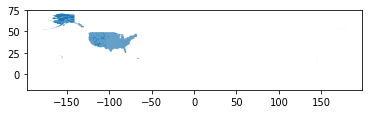

In [339]:
county_shapefile_gdf.plot()

In [340]:
# write to geoJSON
county_shapefile_gdf.to_file("JSON/county_polygons.json", driver="GeoJSON", encoding='utf-8')

# PART 6: State-level summary data (count for all 3 databases, by state)

### 1/5: Get count of missing person cases

In [292]:
missing_count = missing_df.groupby('State').count()
len(missing_count)
missing_count.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
State,,,,,,,,,,,,,,,,
Alabama,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,219
Alaska,582,582,582,582,582,571,582,582,582,582,582,582,582,570,570,519
Arizona,916,916,916,916,916,912,916,916,916,916,916,916,916,883,883,828
Arkansas,280,280,280,280,280,279,280,280,280,280,280,280,280,279,279,271
California,2511,2511,2511,2511,2511,2501,2511,2511,2511,2511,2511,2511,2511,2492,2492,2387


In [294]:
# Remove all columns except case number count
missing_count = missing_count.drop(columns=['DLC','Last Name', 'First Name', 'Missing Age', 'City', 'County', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city'])

In [295]:
# add column for state (since state is now index)
missing_count['State'] = missing_count.index

In [296]:
# rename case number count column
missing_count = missing_count.rename(columns = {'Case Number': 'Missing_CaseCount'}, inplace = False)

In [387]:
# check dataframe
missing_count.head()

,Missing_CaseCount,State
State,,
Alabama,238,Alabama
Alaska,582,Alaska
Arizona,916,Arizona
Arkansas,280,Arkansas
California,2511,California


In [391]:
# make dictionary of states and missing person counts
missing_statecount_dict = dict(zip(missing_count.State, missing_count.Missing_CaseCount))
len(missing_statecount_dict)
# type(missing_statecount_dict['Alabama'])

55

In [299]:
# Get count of values in missing database w/ no state assigned
mis_null_series = missing_df.loc[missing_df['State']=='None'].count()
mis_null_ct = mis_null_series['Case Number']
mis_null_ct

0

### 2/5: Get count of unclaimed persons

In [300]:
unclaimed_count = unclaimed_df.groupby('State').count()
# len(unclaimed_count)
unclaimed_count.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
State,,,,,,,,,,,,,,,
Alabama,63,63,63,63,63,63,63,63,63,63,63,63,63,63,62
Alaska,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
Arizona,21,20,21,21,21,21,20,21,21,21,21,21,20,20,19
Arkansas,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
California,1680,1046,1680,1680,1680,1680,691,1680,1680,1680,1680,1680,691,691,682


In [301]:
# Remove all columns except case number count
unclaimed_count = unclaimed_count.drop(columns=['DBF','Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city'])

In [302]:
# add column for state (since state is now index)
unclaimed_count['State'] = unclaimed_count.index

In [303]:
# rename case number count column
unclaimed_count = unclaimed_count.rename(columns = {'Case Number': 'Unclaimed_CaseCount'}, inplace = False)

In [304]:
# check dataframe
unclaimed_count.head()

,Unclaimed_CaseCount,State
State,,
Alabama,63,Alabama
Alaska,1,Alaska
Arizona,21,Arizona
Arkansas,16,Arkansas
California,1680,California


In [392]:
# make dictionary of states and unclaimed case counts
unclaimed_statecount_dict = dict(zip(unclaimed_count.State, unclaimed_count.Unclaimed_CaseCount))
len(unclaimed_statecount_dict)
# unclaimed_statecount_dict

44

In [306]:
# Get count of values in unclaimed database w/ no state assigned
unc_null_series = unclaimed_df.loc[unclaimed_df['State']=='None'].count()
unc_null_ct = unc_null_series['Case Number']
unc_null_ct

21

### 3/5: Get count of unidentified persons

In [307]:
unidentified_count = unidentified_df.groupby('State').count()
# len(unidentified_count)
unidentified_count.head()

,Case Number,DBF,Age From,Age To,City,County,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
State,,,,,,,,,,,,,,,
Alabama,56,56,56,56,48,56,56,56,56,56,56,56,48,48,46
Alaska,56,56,56,56,50,56,56,56,56,56,56,56,50,50,42
Arizona,1773,1772,1773,1773,1423,1773,1773,1773,1773,1773,1773,1773,1421,1421,1306
Arkansas,100,100,100,100,94,100,100,100,100,100,100,100,94,94,89
California,2741,2740,2741,2741,2214,2741,2741,2741,2741,2741,2741,2741,2211,2211,2153


In [308]:
# Remove all columns except case number count
unidentified_count = unidentified_count.drop(columns=['DBF','Age From', 'Age To', 'City', 'County', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city'])

In [309]:
# add column for state (since state is now index)
unidentified_count['State'] = unidentified_count.index

In [310]:
# rename case number count column
unidentified_count = unidentified_count.rename(columns = {'Case Number': 'Unidentified_CaseCount'}, inplace = False)

In [311]:
# check dataframe
unidentified_count.head()

,Unidentified_CaseCount,State
State,,
Alabama,56,Alabama
Alaska,56,Alaska
Arizona,1773,Arizona
Arkansas,100,Arkansas
California,2741,California


In [393]:
# make dictionary of states and unidentified case counts
unidentified_statecount_dict = dict(zip(unidentified_count.State, unidentified_count.Unidentified_CaseCount))
len(unidentified_statecount_dict)
# unidentified_statecount_dict

54

In [313]:
# Get count of values in unidentified database w/ no state assigned
uni_null_series = unidentified_df.loc[unidentified_df['State']=='None'].count()
uni_null_ct = uni_null_series['Case Number']
uni_null_ct

0

### 4/5: Make summary dataframe based on state centroids

In [ ]:
# make a new summary dataframe based on the state centroids
summary_df = state_centroids_v2_df
# sort by state name
summary_df = summary_df.sort_values(by=['STATEFP'])
summary_df.head()

In [ ]:
# Remove all columns except state info and case number counts
summary_df = summary_df.drop(columns=['OBJECTID','STATENS','AFFGEOID','GEOID','LSAD','ALAND','AWATER','ORIG_FID'])
summary_df.head()

In [ ]:
len(summary_df)

#### 4a: Add Missing Person count for each state

In [ ]:
# Add new column to dataframe, using the state name field as a key in the missing_dict, to pull the correct missing case count for each state
summary_df['Missing_Count'] = summary_df['NAME'].map(missing_statecount_dict)
summary_df.head()

In [ ]:
# Check null values [NOTE: seems fine to have nulls]
missing_null_df = summary_df.loc[summary_df['Missing_Count'].isnull()]
missing_null_df

#### 4b: Add Unclaimed Person count for each state

In [ ]:
# Add new column to dataframe, using the state name field as a key in the unclaimed_dict, to pull the correct unclaimed case count for each state
summary_df['Unclaimed_Count'] = summary_df['NAME'].map(unclaimed_statecount_dict)
summary_df.head()

In [ ]:
# Check null values [NOTE: seems fine to have nulls]
unclaimed_null_df = summary_df.loc[summary_df['Unclaimed_Count'].isnull()]
unclaimed_null_df

In [ ]:
# No longer needed, since summary dataframe now made AFTER data cleaning and adding State with FIPS 99
# # # change NaN Unclaimed count for fake FIPS 99 to count of values in missing database w/ no state assigned (21)
# index_Series = summary_df.loc[summary_df['STATEFP']==99]
# index_None = index_Series.index[0]
# summary_df.loc[index_None, 'Unclaimed_Count'] = unc_null_ct
# # check value
# summary_df['Unclaimed_Count'][index_None]

#### 4c: Add Unidentified Person count for each state

In [ ]:
# Add new column to dataframe, using the state name field as a key in the unidentified_dict, to pull the correct unidentified case count for each state
summary_df['Unidentified_Count'] = summary_df['NAME'].map(unidentified_statecount_dict)
summary_df.head()

In [ ]:
# Check null values [NOTE: seems fine to have nulls]
unidentified_null_df = summary_df.loc[summary_df['Unidentified_Count'].isnull()]
unidentified_null_df

#### 4d: Add column for total count of cases in all three databases for each state

In [ ]:
summary_df.head()

In [ ]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_df['Total_Count'] = summary_df.iloc[:, -4:-1].sum(axis=1)
summary_df.head(56)

#### 4e: Convert to geodataframe and export as GeoJSON

In [ ]:
# check final summary_df
summary_df.head()

In [ ]:
# Convert dataframe to geodataframe
summary_gdf = gpd.GeoDataFrame(summary_df, geometry=gpd.points_from_xy(x=summary_df.Lon_dd, y=summary_df.Lat_dd))
summary_gdf.head()

In [ ]:
# write to geoJSON
summary_gdf.to_file("JSON/summary_counts.json", driver="GeoJSON", encoding='utf-8')

### 5/5: Make summary dataframe based on state polygons

In [377]:
# load state json
summary_state_poly_gdf = gpd.read_file('JSON/state_polygons.json')

In [378]:
summary_state_poly_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,Shape_Leng,Shape_Area,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,1.215335e+11,3.926920e+09,24.609526,11.885422,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,1.259237e+11,1.346607e+10,41.263334,12.782199,"MULTIPOLYGON (((-75.72681 35.93585, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,1.776629e+11,3.374588e+09,27.211118,18.005009,"POLYGON ((-103.00257 36.52659, -103.00220 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,1.022577e+11,8.528532e+09,33.614068,10.685784,"MULTIPOLYGON (((-75.74241 37.80836, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,6.226647e+10,4.890285e+08,20.196988,6.493883,"POLYGON ((-82.64320 38.16910, -82.64300 38.169..."


In [379]:
# Remove all columns except county info and case number counts
summary_state_poly_gdf = summary_state_poly_gdf.drop(columns=['STATENS','AFFGEOID','GEOID', 'LSAD','ALAND','AWATER', 'Shape_Leng', 'Shape_Area'])
summary_state_poly_gdf.head()

,STATEFP,STUSPS,NAME,geometry
0,28,MS,Mississippi,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,NC,North Carolina,"MULTIPOLYGON (((-75.72681 35.93585, -75.71827 ..."
2,40,OK,Oklahoma,"POLYGON ((-103.00257 36.52659, -103.00220 36.6..."
3,51,VA,Virginia,"MULTIPOLYGON (((-75.74241 37.80836, -75.74151 ..."
4,54,WV,West Virginia,"POLYGON ((-82.64320 38.16910, -82.64300 38.169..."


In [380]:
len(summary_state_poly_gdf)

55

In [381]:
# sort by state FIPS
summary_state_poly_gdf = summary_state_poly_gdf.sort_values(by=['STATEFP'])
summary_state_poly_gdf.head()

,STATEFP,STUSPS,NAME,geometry
17,01,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
27,02,AK,Alaska,"MULTIPOLYGON (((179.48245 51.98283, 179.48655 ..."
35,04,AZ,Arizona,"POLYGON ((-114.81631 32.50804, -114.81433 32.5..."
51,05,AR,Arkansas,"POLYGON ((-94.61784 36.49942, -94.61766 36.499..."
16,06,CA,California,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988..."


#### 5a: Add Missing Person count for each state

In [398]:
# Add new column to dataframe, using the state name field as a key in the missing_dict, to pull the correct missing case count for each state
summary_state_poly_gdf['Missing_Count'] = summary_state_poly_gdf['NAME'].map(missing_statecount_dict)
summary_state_poly_gdf.head()

,STATEFP,STUSPS,NAME,geometry,Missing_Count
17,01,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",238
27,02,AK,Alaska,"MULTIPOLYGON (((179.48245 51.98283, 179.48655 ...",582
35,04,AZ,Arizona,"POLYGON ((-114.81631 32.50804, -114.81433 32.5...",916
51,05,AR,Arkansas,"POLYGON ((-94.61784 36.49942, -94.61766 36.499...",280
16,06,CA,California,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988...",2511


#### 5b: Add Unclaimed Person count for each state

In [400]:
# Add new column to dataframe, using the state name field as a key in the unclaimed_dict, to pull the correct unclaimed case count for each state
summary_state_poly_gdf['Unclaimed_Count'] = summary_state_poly_gdf['NAME'].map(unclaimed_statecount_dict)
summary_state_poly_gdf.head()

,STATEFP,STUSPS,NAME,geometry,Missing_Count,Unclaimed_Count
17,01,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",238,63.0
27,02,AK,Alaska,"MULTIPOLYGON (((179.48245 51.98283, 179.48655 ...",582,1.0
35,04,AZ,Arizona,"POLYGON ((-114.81631 32.50804, -114.81433 32.5...",916,21.0
51,05,AR,Arkansas,"POLYGON ((-94.61784 36.49942, -94.61766 36.499...",280,16.0
16,06,CA,California,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988...",2511,1680.0


#### 5c: Add Unidentified Person count for each state

In [401]:
# Add new column to dataframe, using the state name field as a key in the unidentified_dict, to pull the correct unidentified case count for each state
summary_state_poly_gdf['Unidentified_Count'] = summary_state_poly_gdf['NAME'].map(unidentified_statecount_dict)
summary_state_poly_gdf.head()

,STATEFP,STUSPS,NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count
17,01,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",238,63.0,56.0
27,02,AK,Alaska,"MULTIPOLYGON (((179.48245 51.98283, 179.48655 ...",582,1.0,56.0
35,04,AZ,Arizona,"POLYGON ((-114.81631 32.50804, -114.81433 32.5...",916,21.0,1773.0
51,05,AR,Arkansas,"POLYGON ((-94.61784 36.49942, -94.61766 36.499...",280,16.0,100.0
16,06,CA,California,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988...",2511,1680.0,2741.0


#### 5d: Add column for total count of cases in all three databases for each state

In [402]:
summary_state_poly_gdf.head()

,STATEFP,STUSPS,NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count
17,01,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",238,63.0,56.0
27,02,AK,Alaska,"MULTIPOLYGON (((179.48245 51.98283, 179.48655 ...",582,1.0,56.0
35,04,AZ,Arizona,"POLYGON ((-114.81631 32.50804, -114.81433 32.5...",916,21.0,1773.0
51,05,AR,Arkansas,"POLYGON ((-94.61784 36.49942, -94.61766 36.499...",280,16.0,100.0
16,06,CA,California,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988...",2511,1680.0,2741.0


In [405]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_state_poly_gdf['Total_Count'] = summary_state_poly_gdf.iloc[:, -4:-1].sum(axis=1)
summary_state_poly_gdf.head(56)

,STATEFP,STUSPS,NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count,Total_Count
17,01,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",238,63.0,56.0,357.0
27,02,AK,Alaska,"MULTIPOLYGON (((179.48245 51.98283, 179.48655 ...",582,1.0,56.0,639.0
35,04,AZ,Arizona,"POLYGON ((-114.81631 32.50804, -114.81433 32.5...",916,21.0,1773.0,2710.0
51,05,AR,Arkansas,"POLYGON ((-94.61784 36.49942, -94.61766 36.499...",280,16.0,100.0,396.0
16,06,CA,California,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988...",2511,1680.0,2741.0,6932.0
21,08,CO,Colorado,"POLYGON ((-109.06026 38.59933, -109.05955 38.7...",311,6.0,83.0,400.0
54,09,CT,Connecticut,"MULTIPOLYGON (((-72.76143 41.24234, -72.75973 ...",210,100.0,41.0,351.0
42,10,DE,Delaware,"MULTIPOLYGON (((-75.56555 39.51486, -75.56174 ...",58,1.0,30.0,89.0
36,11,DC,District of Columbia,"POLYGON ((-77.11976 38.93435, -77.11253 38.940...",42,20.0,29.0,91.0
9,12,FL,Florida,"MULTIPOLYGON (((-80.17628 25.52506, -80.17395 ...",1493,45.0,900.0,2438.0


#### 5e: Export as GeoJSON

In [406]:
# check final summary_df
summary_state_poly_gdf.head()

,STATEFP,STUSPS,NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count,Total_Count
17,01,AL,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",238,63.0,56.0,357.0
27,02,AK,Alaska,"MULTIPOLYGON (((179.48245 51.98283, 179.48655 ...",582,1.0,56.0,639.0
35,04,AZ,Arizona,"POLYGON ((-114.81631 32.50804, -114.81433 32.5...",916,21.0,1773.0,2710.0
51,05,AR,Arkansas,"POLYGON ((-94.61784 36.49942, -94.61766 36.499...",280,16.0,100.0,396.0
16,06,CA,California,"MULTIPOLYGON (((-118.60443 33.47856, -118.5988...",2511,1680.0,2741.0,6932.0


In [407]:
# write to geoJSON
summary_state_poly_gdf.to_file("JSON/state_poly_counts.json", driver="GeoJSON", encoding='utf-8')

# PART 7: County-level summary data (count for all 3 databases, by county)

### 1/5: Get count of missing person cases at county level

In [314]:
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131,fortsmith,5131_fortsmith,Fort Smith
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001,clinton,47001_clinton,Clinton
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163,kingsport,47163_kingsport,Kingsport
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059,owensboro,21059_owensboro,Owensboro
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105,fallsburg,36105_fallsburg,Fallsburg


In [315]:
missing_county_count = missing_df.groupby('County_FIPS').count()
# len(missing_county_count)
missing_county_count.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,City_string,County_city,GNIS_city
County_FIPS,,,,,,,,,,,,,,,,
1001,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1
1003,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1005,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2
1009,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,3
1013,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [316]:
# Remove all columns except case number count
missing_county_count = missing_county_count.drop(columns=['DLC','Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'City_string', 'County_city', 'GNIS_city'])

In [317]:
# add column for county FIPS (since county FIPS is now index)
missing_county_count['County_FIPS'] = missing_county_count.index

In [318]:
# rename case number count column
missing_county_count = missing_county_count.rename(columns = {'Case Number': 'Missing_CaseCount'}, inplace = False)

In [319]:
# check dataframe
missing_county_count.head()

,Missing_CaseCount,County_FIPS
County_FIPS,,
1001,2,1001
1003,8,1003
1005,3,1005
1009,5,1009
1013,2,1013


In [422]:
# make dictionary of county_FIPS and missing person counts
missing_countycount_dict = dict(zip(missing_county_count.County_FIPS, missing_county_count.Missing_CaseCount))
len(missing_countycount_dict)
# missing_countycount_dict[1001]

2013

### 2/5: Get count of unclaimed person cases at county level

In [321]:
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
4129,UCP3482,1/1/2004,Green,Ellen,Female,White / Caucasian,Orange,Orange,California,4/18/2017,6,6_Orange,6059,orange,6059_orange,Orange
4649,UCP3523,1/1/2005,Baldwin,Bette,Female,White / Caucasian,San Juan Capistrano,Orange,California,4/20/2017,6,6_Orange,6059,sanjuancapistrano,6059_sanjuancapistrano,San Juan Capistrano
7297,UCP853,1/1/2006,Eckberg,Robert,Male,White / Caucasian,NaN,Spokane,Washington,4/14/2020,53,53_Spokane,53063,NaN,NaN,NaN
7256,UCP63328,1/1/2007,Bishop,Robert,Unknown,Uncertain,NaN,San Bernardino,California,12/19/2019,6,6_San Bernardino,6071,NaN,NaN,NaN
2236,UCP3793,1/1/2007,Lopez,Agnes,Female,White / Caucasian,Fullerton,Orange,California,5/4/2017,6,6_Orange,6059,fullerton,6059_fullerton,Fullerton


In [322]:
unclaimed_county_count = unclaimed_df.groupby('County_FIPS').count()
# len(unclaimed_county_count)
unclaimed_county_count.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,City_string,County_city,GNIS_city
County_FIPS,,,,,,,,,,,,,,,
1073,62,62,62,62,62,62,62,62,62,62,62,62,62,62,61
1115,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2013,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4007,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4013,6,5,6,6,6,6,5,6,6,6,6,6,5,5,5


In [323]:
# Remove all columns except case number count
unclaimed_county_count = unclaimed_county_count.drop(columns=['DBF','Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'City_string', 'County_city', 'GNIS_city'])

In [324]:
# add column for county FIPS (since county FIPS is now index)
unclaimed_county_count['County_FIPS'] = unclaimed_county_count.index

In [325]:
# rename case number count column
unclaimed_county_count = unclaimed_county_count.rename(columns = {'Case Number': 'Unclaimed_CaseCount'}, inplace = False)

In [326]:
# check dataframe
unclaimed_county_count.head()

,Unclaimed_CaseCount,County_FIPS
County_FIPS,,
1073,62,1073
1115,1,1115
2013,1,2013
4007,1,4007
4013,6,4013


In [419]:
# make dictionary of county_FIPS and missing person counts
unclaimed_countycount_dict = dict(zip(unclaimed_county_count.County_FIPS, unclaimed_county_count.Unclaimed_CaseCount))
len(unclaimed_countycount_dict)
# unclaimed_countycount_dict

230

### 3/5: Get count of unidentified person cases at county level

In [328]:
unidentified_df.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
0,UP51903,3/30/1986,0.0,120.0,Marbury,Autauga,Alabama,Female,White / Caucasian,1/28/2020,1,1_Autauga,1001,marbury,1001_marbury,Marbury
1,UP5000,9/29/2007,40.0,60.0,Prattville,Autauga,Alabama,Female,Black / African American,8/12/2019,1,1_Autauga,1001,prattville,1001_prattville,Prattville
2,UP6519,1/6/2006,45.0,59.0,Elberta,Baldwin,Alabama,Male,White / Caucasian,10/24/2018,1,1_Baldwin,1003,elberta,1003_elberta,Elberta
3,UP55409,3/26/2000,0.0,120.0,NaN,Baldwin,Alabama,Male,"White / Caucasian, Asian, American Indian / Al...",2/13/2020,1,1_Baldwin,1003,NaN,NaN,NaN
4,UP13483,3/27/1961,14.0,17.0,NaN,Bibb,Alabama,Male,White / Caucasian,3/25/2019,1,1_Bibb,1007,NaN,NaN,NaN


In [329]:
unidentified_county_count = unidentified_df.groupby('County_FIPS').count()
# len(unidentified_county_count)
unidentified_county_count.head()

,Case Number,DBF,Age From,Age To,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,City_string,County_city,GNIS_city
County_FIPS,,,,,,,,,,,,,,,
1001,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1003,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1
1007,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1009,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1051,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [330]:
# Remove all columns except case number count
unidentified_county_count = unidentified_county_count.drop(columns=['DBF','Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'City_string', 'County_city', 'GNIS_city'])

In [331]:
# add column for county FIPS (since county FIPS is now index)
unidentified_county_count['County_FIPS'] = unidentified_county_count.index

In [332]:
# rename case number count column
unidentified_county_count = unidentified_county_count.rename(columns = {'Case Number': 'Unidentified_CaseCount'}, inplace = False)

In [333]:
# check dataframe
unidentified_county_count.head()

,Unidentified_CaseCount,County_FIPS
County_FIPS,,
1001,2,1001
1003,2,1003
1007,1,1007
1009,1,1009
1051,1,1051


In [396]:
# make dictionary of county_FIPS and missing person counts
unidentified_countycount_dict = dict(zip(unidentified_county_count.County_FIPS, unidentified_county_count.Unidentified_CaseCount))
len(unidentified_countycount_dict)
# unidentified_countycount_dict

1253

### 4/5: Make summary county-level dataframe based on county centroids

In [ ]:
county_centroids_v2_df.head()

In [ ]:
len(county_centroids_v2_df)

In [ ]:
# make a new summary dataframe based on the county centroids
summary_county_df = county_centroids_v2_df
# sort by county FIPS
summary_county_df = summary_county_df.sort_values(by=['GEOID'])
summary_county_df.head()

In [ ]:
# Remove all columns except county info and case number counts
summary_county_df = summary_county_df.drop(columns=['OBJECTID','COUNTYFP','COUNTYNS','AFFGEOID','LSAD','ALAND','AWATER','ORIG_FID'])
summary_county_df.head()

In [ ]:
len(summary_county_df)

#### 4a: Add Missing Person count for each county

In [ ]:
# Add new column to dataframe, using the county FIPS field as a key in the missing_county_dict, to pull the correct missing case count for each county
summary_county_df['Missing_Count'] = summary_county_df['GEOID'].map(missing_countycount_dict)
summary_county_df.head()

In [ ]:
# Check null values [NOTE: fine to have nulls]
missing_county_null_df = summary_county_df.loc[summary_county_df['Missing_Count'].isnull()]
missing_county_null_df

#### 4b: Add Unclaimed Person count for each county

In [ ]:
# Add new column to dataframe, using the county FIPS field as a key in the unclaimed_county_dict, to pull the correct unclaimed case count for each county
summary_county_df['Unclaimed_Count'] = summary_county_df['GEOID'].map(unclaimed_countycount_dict)
summary_county_df.head()

In [ ]:
# Check null values [NOTE: fine to have nulls]
unclaimed_county_null_df = summary_county_df.loc[summary_county_df['Unclaimed_Count'].isnull()]
unclaimed_county_null_df

#### 4c: Add Unidentified Person count for each county

In [ ]:
# Add new column to dataframe, using the county_FIPS field as a key in the unidentified_county_dict, to pull the correct unidentified case count for each county
summary_county_df['Unidentified_Count'] = summary_county_df['GEOID'].map(unidentified_countycount_dict)
summary_county_df.head()

In [ ]:
# Check null values [NOTE: fine to have nulls]
unidentified_county_null_df = summary_county_df.loc[summary_county_df['Unidentified_Count'].isnull()]
unidentified_county_null_df

#### 4d: Add column for total count of cases in all three databases for each county

In [ ]:
summary_county_df.head()

In [ ]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_county_df['Total_Count'] = summary_county_df.iloc[:, -4:-1].sum(axis=1)
summary_county_df.head()

#### 4e: Convert to geodataframe and export as GeoJSON

In [ ]:
# check final summary_county_df
summary_county_df.head()

In [ ]:
len(summary_county_df)

In [ ]:
# Convert dataframe to geodataframe
summary_county_gdf = gpd.GeoDataFrame(summary_county_df, geometry=gpd.points_from_xy(x=summary_county_df.Lon_dd, y=summary_county_df.Lat_dd))
summary_county_gdf.head()

In [ ]:
len(summary_county_gdf)

In [ ]:
# write to geoJSON
summary_county_gdf.to_file("JSON/county_counts.json", driver="GeoJSON", encoding='utf-8')

### 5/5: Make summary county-level dataframe based on county polygons

In [408]:
# load county json
summary_county_poly_gdf = gpd.read_file('JSON/county_polygons.json')

In [409]:
summary_county_poly_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Shape_Leng,Shape_Area,STUSPS,STATE_NAME,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,6.393875e+08,69473325.0,1.257083,0.071780,KY,Kentucky,"POLYGON ((-89.18137 37.04631, -89.17939 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,7.504394e+08,4829777.0,1.715090,0.077688,KY,Kentucky,"POLYGON ((-84.44267 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1.103572e+09,13943044.0,2.062167,0.113459,KY,Kentucky,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,6.555099e+08,6516335.0,1.638294,0.067647,KY,Kentucky,"POLYGON ((-84.12662 37.64541, -84.12484 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,9.027272e+08,7182793.0,2.029347,0.093800,KY,Kentucky,"POLYGON ((-83.98429 38.44550, -83.98246 38.450..."


In [410]:
# Remove all columns except county info and case number counts
summary_county_poly_gdf = summary_county_poly_gdf.drop(columns=['COUNTYFP','COUNTYNS','AFFGEOID','LSAD','ALAND','AWATER','Shape_Leng', 'Shape_Area'])
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry
0,21,21007,Ballard,KY,Kentucky,"POLYGON ((-89.18137 37.04631, -89.17939 37.053..."
1,21,21017,Bourbon,KY,Kentucky,"POLYGON ((-84.44267 38.28324, -84.44114 38.283..."
2,21,21031,Butler,KY,Kentucky,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,21065,Estill,KY,Kentucky,"POLYGON ((-84.12662 37.64541, -84.12484 37.646..."
4,21,21069,Fleming,KY,Kentucky,"POLYGON ((-83.98429 38.44550, -83.98246 38.450..."


In [411]:
len(summary_county_poly_gdf)

3228

In [412]:
# sort by county FIPS
summary_county_poly_gdf = summary_county_poly_gdf.sort_values(by=['GEOID'])
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry
16,01,01001,Autauga,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658..."
2754,01,01003,Baldwin,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230..."
17,01,01005,Barbour,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618..."
2336,01,01007,Bibb,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006..."
1020,01,01009,Blount,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857..."


In [424]:
type(summary_county_poly_gdf['GEOID'][0])

str

In [425]:
summary_county_poly_gdf['GEOID'] = summary_county_poly_gdf['GEOID'].astype(int)

In [426]:
type(summary_county_poly_gdf['GEOID'][0])

numpy.int32

#### 5a: Add Missing Person count for each county

In [428]:
# Add new column to dataframe, using the county FIPS field as a key in the missing_county_dict, to pull the correct missing case count for each county
summary_county_poly_gdf['Missing_Count'] = summary_county_poly_gdf['GEOID'].map(missing_countycount_dict)
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry,Missing_Count
16,01,1001,Autauga,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658...",2.0
2754,01,1003,Baldwin,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230...",8.0
17,01,1005,Barbour,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618...",3.0
2336,01,1007,Bibb,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006...",NaN
1020,01,1009,Blount,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857...",5.0


#### 5b: Add Unclaimed Person count for each county

In [432]:
# Add new column to dataframe, using the county FIPS field as a key in the unclaimed_county_dict, to pull the correct unclaimed case count for each county
summary_county_poly_gdf['Unclaimed_Count'] = summary_county_poly_gdf['GEOID'].map(unclaimed_countycount_dict)
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry,Missing_Count,Unclaimed_Count
16,01,1001,Autauga,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658...",2.0,NaN
2754,01,1003,Baldwin,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230...",8.0,NaN
17,01,1005,Barbour,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618...",3.0,NaN
2336,01,1007,Bibb,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006...",NaN,NaN
1020,01,1009,Blount,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857...",5.0,NaN


#### 5c: Add Unidentified Person count for each county

In [433]:
# Add new column to dataframe, using the county_FIPS field as a key in the unidentified_county_dict, to pull the correct unidentified case count for each county
summary_county_poly_gdf['Unidentified_Count'] = summary_county_poly_gdf['GEOID'].map(unidentified_countycount_dict)
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count
16,01,1001,Autauga,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658...",2.0,NaN,2.0
2754,01,1003,Baldwin,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230...",8.0,NaN,2.0
17,01,1005,Barbour,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618...",3.0,NaN,NaN
2336,01,1007,Bibb,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006...",NaN,NaN,1.0
1020,01,1009,Blount,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857...",5.0,NaN,1.0


#### 5d: Add column for total count of cases in all three databases for each county

In [434]:
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count
16,01,1001,Autauga,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658...",2.0,NaN,2.0
2754,01,1003,Baldwin,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230...",8.0,NaN,2.0
17,01,1005,Barbour,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618...",3.0,NaN,NaN
2336,01,1007,Bibb,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006...",NaN,NaN,1.0
1020,01,1009,Blount,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857...",5.0,NaN,1.0


In [439]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_county_poly_gdf['Total_Count'] = summary_county_poly_gdf.iloc[:, -4:-1].sum(axis=1)
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count,Total_Count
16,01,1001,Autauga,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658...",2.0,NaN,2.0,4.0
2754,01,1003,Baldwin,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230...",8.0,NaN,2.0,10.0
17,01,1005,Barbour,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618...",3.0,NaN,NaN,3.0
2336,01,1007,Bibb,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006...",NaN,NaN,1.0,1.0
1020,01,1009,Blount,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857...",5.0,NaN,1.0,6.0


#### 5e: Export as GeoJSON

In [440]:
# check final summary_county_poly_gdf
summary_county_poly_gdf.head()

,STATEFP,GEOID,NAME,STUSPS,STATE_NAME,geometry,Missing_Count,Unclaimed_Count,Unidentified_Count,Total_Count
16,01,1001,Autauga,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658...",2.0,NaN,2.0,4.0
2754,01,1003,Baldwin,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230...",8.0,NaN,2.0,10.0
17,01,1005,Barbour,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618...",3.0,NaN,NaN,3.0
2336,01,1007,Bibb,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006...",NaN,NaN,1.0,1.0
1020,01,1009,Blount,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857...",5.0,NaN,1.0,6.0


In [441]:
len(summary_county_poly_gdf)

3228

In [442]:
# write to geoJSON
summary_county_poly_gdf.to_file("JSON/county_poly_counts.json", driver="GeoJSON", encoding='utf-8')

# PART 8: City-level summary data (count for all 3 databases, by city)

### 1/4: Get count of missing person cases at city level

In [ ]:
missing_df.head()

In [ ]:
missing_city_count = missing_df.groupby('County_city').count()
# len(missing_city_count)
missing_city_count.head()

In [ ]:
# Remove all columns except case number count
missing_city_count = missing_city_count.drop(columns=['DLC','Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'GNIS_city'])

In [ ]:
# add column for county city (since county city is now index)
missing_city_count['County_city'] = missing_city_count.index

In [ ]:
# rename case number count column
missing_city_count = missing_city_count.rename(columns = {'Case Number': 'Missing_CaseCount'}, inplace = False)

In [ ]:
# check dataframe
missing_city_count.head()

In [ ]:
# make dictionary of county_city and missing person counts
missing_city_dict = dict(zip(missing_city_count.County_city, missing_city_count.Missing_CaseCount))
len(missing_city_dict)
# missing_city_dict

### 2/4: Get count of unclaimed person cases at city level

In [ ]:
unclaimed_df.head()

In [ ]:
unclaimed_city_count = unclaimed_df.groupby('County_city').count()
# len(unclaimed_city_count)
unclaimed_city_count.head()

In [ ]:
# Remove all columns except case number count
unclaimed_city_count = unclaimed_city_count.drop(columns=['DBF','Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'GNIS_city'])

In [ ]:
# add column for county_city (since county_city is now index)
unclaimed_city_count['County_city'] = unclaimed_city_count.index

In [ ]:
# rename case number count column
unclaimed_city_count = unclaimed_city_count.rename(columns = {'Case Number': 'Unclaimed_CaseCount'}, inplace = False)

In [ ]:
# check dataframe
unclaimed_city_count.head()

In [ ]:
# make dictionary of county_city and missing person counts
unclaimed_city_dict = dict(zip(unclaimed_city_count.County_city, unclaimed_city_count.Unclaimed_CaseCount))
len(unclaimed_city_dict)
# unclaimed_city_dict

### 3/4: Get count of unidentified person cases at city level

In [ ]:
unidentified_df.head()

In [ ]:
unidentified_city_count = unidentified_df.groupby('County_city').count()
# len(unidentified_city_count)
unidentified_city_count.head()

In [ ]:
# Remove all columns except case number count
unidentified_city_count = unidentified_city_count.drop(columns=['DBF','Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'GNIS_city'])

In [ ]:
# add column for county_city (since county_city is now index)
unidentified_city_count['County_city'] = unidentified_city_count.index

In [ ]:
# rename case number count column
unidentified_city_count = unidentified_city_count.rename(columns = {'Case Number': 'Unidentified_CaseCount'}, inplace = False)

In [ ]:
# check dataframe
unidentified_city_count.head()

In [ ]:
# make dictionary of county_city and missing person counts
unidentified_city_dict = dict(zip(unidentified_city_count.County_city, unidentified_city_count.Unidentified_CaseCount))
len(unidentified_city_dict)
# unidentified_city_dict

### 4/4: Make summary city-level dataframe

In [ ]:
city_df.head()

In [ ]:
len(city_df)

In [ ]:
# make a new summary dataframe based on the city centroids
summary_city_df = city_df
# sort by countyfp_city
summary_city_df = summary_city_df.sort_values(by=['COUNTYFP_CITY'])
summary_city_df.head()

In [ ]:
len(summary_city_df)

#### 4a: Add Missing Person count for each city

In [ ]:
# Add new column to dataframe, using the countyfp_city field as a key in the missing_city_dict, to pull the correct missing case count for each city
summary_city_df['Missing_Count'] = summary_city_df['COUNTYFP_CITY'].map(missing_city_dict)
summary_city_df.head()

In [ ]:
# Check null values [NOTE: fine to have nulls]
missing_city_null_df = summary_city_df.loc[summary_city_df['Missing_Count'].isnull()]
missing_city_null_df

#### 4b: Add Unclaimed Person count for each city

In [ ]:
# Add new column to dataframe, using the countyfp_city field as a key in the unclaimed_city_dict, to pull the correct unclaimed case count for each city
summary_city_df['Unclaimed_Count'] = summary_city_df['COUNTYFP_CITY'].map(unclaimed_city_dict)
summary_city_df.head()

In [ ]:
# Check null values [NOTE: fine to have nulls]
unclaimed_city_null_df = summary_city_df.loc[summary_city_df['Unclaimed_Count'].isnull()]
unclaimed_city_null_df

#### 4c: Add Unidentified Person count for each city

In [ ]:
# Add new column to dataframe, using the countyfp_city field as a key in the unidentified_city_dict, to pull the correct unidentified case count for each city
summary_city_df['Unidentified_Count'] = summary_city_df['COUNTYFP_CITY'].map(unidentified_city_dict)
summary_city_df.head()

In [ ]:
# Check null values [NOTE: fine to have nulls]
unidentified_city_null_df = summary_city_df.loc[summary_city_df['Unidentified_Count'].isnull()]
unidentified_city_null_df

#### 4d: Add column for total count of cases in all three databases for each city

In [ ]:
summary_city_df.head()

In [ ]:
# Note - may need to change -4 to -3, run, then change back to -4 and re-run. DON'T KNOW WHY
summary_city_df['Total_Count'] = summary_city_df.iloc[:, -4:-1].sum(axis=1)
summary_city_df.head(120780)

In [ ]:
len(summary_city_df)

In [ ]:
summary_city_zeros_df = summary_city_df.loc[summary_city_df['Total_Count']==0]
summary_city_zeros_df.shape

In [ ]:
199473-193048

In [ ]:
final_summary_city_df = summary_city_df[summary_city_df['Total_Count'] != 0]
final_summary_city_df.shape

In [ ]:
# check dataframe
final_summary_city_df.head(20)

In [ ]:
# reset index of dataframe
final_summary_city_df = final_summary_city_df.reset_index(drop=True)
final_summary_city_df.head()

#### 4e: Convert to geodataframe and export as GeoJSON

In [ ]:
# check final summary_city_df
final_summary_city_df.head(20)

In [ ]:
len(final_summary_city_df)

In [ ]:
# Convert dataframe to geodataframe
final_summary_city_gdf = gpd.GeoDataFrame(final_summary_city_df, geometry=gpd.points_from_xy(x=final_summary_city_df.Lon_dd, y=final_summary_city_df.Lat_dd))
final_summary_city_gdf.head()

In [ ]:
len(final_summary_city_gdf)

In [ ]:
# write to geoJSON
final_summary_city_gdf.to_file("JSON/city_counts.json", driver="GeoJSON", encoding='utf-8')

# PART 9 - construct state-, county-, and city-level GeoJSON files - CENTROIDS

### Construct State-level GeoJSON with correct structure

Goal format:
{
"type": "Feature",
    "name": "Wisconsin",
    "properties": {
        "missing": [ ],
        "unclaimed": [ ],
        "unidentified": [ ],
        "filtered": [ ]
    }
    "geometry": {
          "type": "Point",
          "coordinates": [
            -117.79750667,
            36.03755926
          ]
}
* each array will be a list of dictionaries. Each dictionary = one case. Keys = headers

In [ ]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

In [ ]:
# check df
unclaimed_df.head()

In [ ]:
# check data types
type(unclaimed_df['State_FIPS'][0])

In [ ]:
# check centroids
state_centroids_v2_df.head()
len(state_centroids_v2_df)

In [ ]:
# sort each database by state FIPS
# sort state centroids by state FIPS
state_centroids_v2_df = state_centroids_v2_df.sort_values(by=['STATEFP'])
state_centroids_v2_df.head()

In [ ]:
# sort each database by state FIPS
# sort missing by state FIPS
missing_df = missing_df.sort_values(by=['State_FIPS'])
missing_df.head()

In [ ]:
# sort unclaimed by state FIPS
unclaimed_df = unclaimed_df.sort_values(by=['State_FIPS'])
unclaimed_df.head()

In [ ]:
# sort unidentified by state FIPS
unidentified_df = unidentified_df.sort_values(by=['State_FIPS'])
unidentified_df.head()

In [ ]:
## Create state array
state_array = []
## for each state in state_centroids...
i = 0
while i < len(state_centroids_v2_df):
    state_dict = {}
    state_dict["type"] = "Feature"
    state_dict["name"] = state_centroids_v2_df["NAME"][i]
    state_dict["name_abbr"] = state_centroids_v2_df["STUSPS"][i]
    state_dict["state_FIPS"] = str(state_centroids_v2_df["STATEFP"][i])
    state_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if state_fips matches
        if missing_df['State_FIPS'][j] == state_centroids_v2_df["STATEFP"][i]:
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    state_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if state_fips matches
        if unclaimed_df['State_FIPS'][k] == state_centroids_v2_df["STATEFP"][i]:
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    state_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if state_fips matches
        if unidentified_df['State_FIPS'][l] == state_centroids_v2_df["STATEFP"][i]:
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    state_dict["properties"]['unidentified'] = unidentified_array
    
    state_dict["properties"]['filtered'] = []
    ## set geometry
    state_dict["geometry"] = {}
    state_dict["geometry"]["type"] = "Point"
    state_dict["geometry"]["coordinates"] = [state_centroids_v2_df['Lon_dd'][i], state_centroids_v2_df['Lat_dd'][i]]
    ## append state dictionary to array
    state_array.append(state_dict)
    # test statement
    print("added state", str(i+1), "of 56")
    # increment interator
    i += 1
# state_array

In [ ]:
# check item in array
len(state_array)
# state_array[0]['properties']['unclaimed']

In [ ]:
# Create FeatureCollection
state_feature_collection = {}
state_feature_collection["type"] = "FeatureCollection"
state_feature_collection["features"] = state_array
# state_feature_collection

In [ ]:
# Convert FeatureCollection to JSON format
state_geojson = geojson.dumps(state_feature_collection)
# check type to make sure conversion was sucessful
print(type(state_geojson))

In [ ]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/state_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(state_geojson)

### Construct COUNTY-LEVEL GeoJSON with correct structure

Goal format:
{
"type": "Feature",
    "name": "Dane",
    "state": "Wisconsin",
    "state_FIPS": ,
    "county_FIPS": ,
    "properties": {
        "missing": [ ],
        "unclaimed": [ ],
        "unidentified": [ ],
        "filtered": [ ]
    }
    "geometry": {
          "type": "Point",
          "coordinates": [
            -117.79750667,
            36.03755926
          ]
}
* each array will be a list of dictionaries. Each dictionary = one case. Keys = headers

In [ ]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

In [ ]:
# check df
unclaimed_df.head()

In [ ]:
# check data types
type(unclaimed_df['State_FIPS'][0])

In [ ]:
# check centroids
county_centroids_v2_df.head()
len(county_centroids_v2_df)

In [ ]:
# sort each database by county FIPS
# sort county centroids by county FIPS
county_centroids_v2_df = county_centroids_v2_df.sort_values(by=['GEOID'])
county_centroids_v2_df.head()

In [ ]:
# sort each database by county FIPS
# sort missing by county FIPS
missing_df = missing_df.sort_values(by=['County_FIPS'])
missing_df.head()

In [ ]:
# sort unclaimed by county FIPS
unclaimed_df = unclaimed_df.sort_values(by=['County_FIPS'])
unclaimed_df.head()

In [ ]:
# sort unidentified by county FIPS
unidentified_df = unidentified_df.sort_values(by=['County_FIPS'])
unidentified_df.head()

In [ ]:
## Create county array 
county_array = []
## for each county in county_centroids_v2...
i = 0
while i < len(county_centroids_v2_df):
    county_dict = {}
    county_dict["type"] = "Feature"
    county_dict["name"] = str(county_centroids_v2_df["NAME"][i])
    county_dict["county_FIPS"] = str(county_centroids_v2_df["GEOID"][i])
    county_dict["state_name"] = str(county_centroids_v2_df["STATE_NAME"][i])
    county_dict["state_FIPS"] = str(county_centroids_v2_df["STATEFP"][i])
    county_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if county_fips matches
        if missing_df['County_FIPS'][j] == county_centroids_v2_df["GEOID"][i]:
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    county_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if county_fips matches
        if unclaimed_df['County_FIPS'][k] == county_centroids_v2_df["GEOID"][i]:
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    county_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if county_fips matches
        if unidentified_df['County_FIPS'][l] == county_centroids_v2_df["GEOID"][i]:
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    county_dict["properties"]['unidentified'] = unidentified_array
    
    county_dict["properties"]['filtered'] = []
    ## set geometry
    county_dict["geometry"] = {}
    county_dict["geometry"]["type"] = "Point"
    county_dict["geometry"]["coordinates"] = [county_centroids_v2_df['Lon_dd'][i], county_centroids_v2_df['Lat_dd'][i]]
    ## append county dictionary to array
    county_array.append(county_dict)
    # test statement
    print("added county", str(i+1), "of 3284")
    # increment interator
    i += 1
# county_array

In [ ]:
# check item in array
len(county_array)
# county_array[55]['properties']['unclaimed']

In [ ]:
# Create FeatureCollection
county_feature_collection = {}
county_feature_collection["type"] = "FeatureCollection"
county_feature_collection["features"] = county_array
# county_feature_collection

In [ ]:
# Convert FeatureCollection to JSON format
county_geojson = geojson.dumps(county_feature_collection)
# check type to make sure conversion was sucessful
print(type(county_geojson))

In [ ]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/county_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(county_geojson)

### Construct CITY-LEVEL GeoJSON with correct structure

Goal format:
{
"type": "Feature",
    "name": "Dane",
    "state": "Wisconsin",
    "state_FIPS": ,
    "county_FIPS": ,
    "properties": {
        "missing": [ ],
        "unclaimed": [ ],
        "unidentified": [ ],
        "filtered": [ ]
    }
    "geometry": {
          "type": "Point",
          "coordinates": [
            -117.79750667,
            36.03755926
          ]
}
* each array will be a list of dictionaries. Each dictionary = one case. Keys = headers

In [ ]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

In [ ]:
# check citiess
final_summary_city_df.head()
# len(final_summary_city_df)

In [ ]:
# sort each database by county FIPS
# sort county centroids by county FIPS
final_summary_city_df = final_summary_city_df.sort_values(by=['COUNTYFP_CITY'])
final_summary_city_df.head()

In [ ]:
# sort each database by county_FIPS_city
# sort missing by county FIPS
missing_df = missing_df.sort_values(by=['County_city'])
missing_df.head()

In [ ]:
# sort unclaimed by county FIPS
unclaimed_df = unclaimed_df.sort_values(by=['County_city'])
unclaimed_df.head()

In [ ]:
# sort unidentified by county FIPS
unidentified_df = unidentified_df.sort_values(by=['County_city'])
unidentified_df.head()

In [ ]:
final_summary_city_df.head()

In [ ]:
len(final_summary_city_df)

In [ ]:
final_summary_city_df["CITY_NAME"][0]

In [ ]:
## Create county array 
city_array = []
## for each city in final_summary_city_df... len(city_df)
i = 0
while i < len(final_summary_city_df):
    city_dict = {}
    city_dict["type"] = "Feature"
    city_dict["name"] = str(final_summary_city_df["CITY_NAME"][i])
    city_dict["city_code"] = str(final_summary_city_df["COUNTYFP_CITY"][i])
    city_dict["county_name"] = str(final_summary_city_df["COUNTY_NAME"][i])
    city_dict["county_FIPS"] = str(final_summary_city_df["COUNTY_FIPS"][i])
    city_dict["state_name"] = str(final_summary_city_df["STATE_NAME"][i])
    city_dict["state_abbr"] = str(final_summary_city_df["STUSPS"][i])
    city_dict["state_FIPS"] = str(final_summary_city_df["STATEFP"][i])
    
    city_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if county_city code matches
        if missing_df['County_city'][j] == final_summary_city_df["COUNTYFP_CITY"][i]:
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    city_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if county_city code matches
        if unclaimed_df['County_city'][k] == final_summary_city_df["COUNTYFP_CITY"][i]:
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    city_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if county_city code matches
        if unidentified_df['County_city'][l] == final_summary_city_df["COUNTYFP_CITY"][i]:
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    city_dict["properties"]['unidentified'] = unidentified_array
    
    city_dict["properties"]['filtered'] = []
    ## set geometry
    city_dict["geometry"] = {}
    city_dict["geometry"]["type"] = "Point"
    city_dict["geometry"]["coordinates"] = [final_summary_city_df['Lon_dd'][i], final_summary_city_df['Lat_dd'][i]]
    ## append county dictionary to array
    city_array.append(city_dict)
    # test statement
    print("added city", str(i+1), "of 6425")
    # increment interator
    i += 1
# city_array[0]

In [ ]:
# check item in array
len(city_array)
# city_array[55]['properties']['unclaimed']

In [ ]:
# Create FeatureCollection
city_feature_collection = {}
city_feature_collection["type"] = "FeatureCollection"
city_feature_collection["features"] = city_array
# city_feature_collection

In [ ]:
# Convert FeatureCollection to JSON format
city_geojson = geojson.dumps(city_feature_collection)
# check type to make sure conversion was sucessful
print(type(city_geojson))

In [ ]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/city_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(city_geojson)

# PART 9 - construct state-, and county--level GeoJSON files - POLYGONS

### Part 1/2 Construct State-level GeoJSON with correct structure - mapped to polygons

In [ ]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

In [ ]:
# load state json
state_gpd = gpd.read_file('JSON/state_polygons.json')

In [ ]:
state_gpd.head()

In [ ]:
# convert to dictionary
state_polygons = state_gpd.to_dict(orient='records')

In [ ]:
len(state_polygons)

In [ ]:
type(missing_df['State_FIPS'][0])

In [ ]:
type(state_polygons[0]["STATEFP"])

In [ ]:
state_polygons[0]

In [ ]:
## Create state array
state_poly_array = []
## for each state in state_centroids...
i = 0
while i < len(state_polygons):
    state_poly_dict = {}
    state_poly_dict["type"] = "Feature"
    state_poly_dict["name"] = state_polygons[i]["NAME"]
    state_poly_dict["name_abbr"] = state_polygons[i]["STUSPS"]
    state_poly_dict["state_FIPS"] = state_polygons[i]["STATEFP"]
    state_poly_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if state_fips matches
        if missing_df['State_FIPS'][j] == int(state_polygons[i]["STATEFP"]):
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    state_poly_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if state_fips matches
        if unclaimed_df['State_FIPS'][k] == int(state_polygons[i]["STATEFP"]):
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    state_poly_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if state_fips matches
        if unidentified_df['State_FIPS'][l] == int(state_polygons[i]["STATEFP"]):
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    state_poly_dict["properties"]['unidentified'] = unidentified_array
    
    state_poly_dict["properties"]['filtered'] = []
    ## set geometry
    state_poly_dict["geometry"] = state_polygons[i]["geometry"]
    ## append state dictionary to array
    state_poly_array.append(state_poly_dict)
    # test statement
    print("added state", str(i+1), "of", len(state_polygons))
    # increment interator
    i += 1
# state_poly_array

In [ ]:
# check item in array
# len(state_poly_array)
# state_poly_array[9]['properties']['unclaimed'][0]
state_poly_array[9]['geometry']

In [ ]:
# Create FeatureCollection
state_poly_feature_collection = {}
state_poly_feature_collection["type"] = "FeatureCollection"
state_poly_feature_collection["features"] = state_poly_array
# state_poly_feature_collection

In [ ]:
# Convert FeatureCollection to JSON format
state_poly_geojson = geojson.dumps(state_poly_feature_collection)
# check type to make sure conversion was sucessful
print(type(state_poly_geojson))

In [ ]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/state_poly_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(state_poly_geojson)

### Part 2/2 Construct COUNTY-LEVEL GeoJSON with correct structure - mapped to polygons

In [443]:
# get headers
missing_header = list(missing_df.columns.values)
print("missing header:", missing_header)
unclaimed_header = list(unclaimed_df.columns.values)
print("unclaimed header:", unclaimed_header)
unidentified_header = list(unidentified_df.columns.values)
print("unidentified header:", unidentified_header)

missing header: ['Case Number', 'DLC', 'Last Name', 'First Name', 'Missing Age', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unclaimed header: ['Case Number', 'DBF', 'Last Name', 'First Name', 'Sex', 'Race / Ethnicity', 'City', 'County', 'State', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']
unidentified header: ['Case Number', 'DBF', 'Age From', 'Age To', 'City', 'County', 'State', 'Sex', 'Race / Ethnicity', 'Date Modified', 'State_FIPS', 'State_County', 'County_FIPS', 'City_string', 'County_city', 'GNIS_city']


In [444]:
# load county json
county_gpd = gpd.read_file('JSON/county_polygons.json')

In [445]:
county_gpd.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Shape_Leng,Shape_Area,STUSPS,STATE_NAME,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,6.393875e+08,69473325.0,1.257083,0.071780,KY,Kentucky,"POLYGON ((-89.18137 37.04631, -89.17939 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,7.504394e+08,4829777.0,1.715090,0.077688,KY,Kentucky,"POLYGON ((-84.44267 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1.103572e+09,13943044.0,2.062167,0.113459,KY,Kentucky,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,6.555099e+08,6516335.0,1.638294,0.067647,KY,Kentucky,"POLYGON ((-84.12662 37.64541, -84.12484 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,9.027272e+08,7182793.0,2.029347,0.093800,KY,Kentucky,"POLYGON ((-83.98429 38.44550, -83.98246 38.450..."


In [463]:
# sort county centroids by state FIPS
county_gpd = county_gpd.sort_values(by=['GEOID'])
county_gpd.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Shape_Leng,Shape_Area,STUSPS,STATE_NAME,geometry
16,01,001,00161526,0500000US01001,01001,Autauga,06,1.539602e+09,2.570696e+07,2.052740,0.150256,AL,Alabama,"POLYGON ((-86.92120 32.65755, -86.92036 32.658..."
2754,01,003,00161527,0500000US01003,01003,Baldwin,06,4.117547e+09,1.133056e+09,4.277935,0.409926,AL,Alabama,"POLYGON ((-88.02859 30.22677, -88.02400 30.230..."
17,01,005,00161528,0500000US01005,01005,Barbour,06,2.292145e+09,5.053870e+07,2.567149,0.223255,AL,Alabama,"POLYGON ((-85.74804 31.61919, -85.74544 31.618..."
2336,01,007,00161529,0500000US01007,01007,Bibb,06,1.612167e+09,9.602089e+06,1.886955,0.156525,AL,Alabama,"POLYGON ((-87.42194 33.00339, -87.31854 33.006..."
1020,01,009,00161530,0500000US01009,01009,Blount,06,1.670104e+09,1.501542e+07,2.392327,0.164403,AL,Alabama,"POLYGON ((-86.96336 33.85823, -86.95967 33.857..."


In [464]:
# convert to dictionary
county_polygons = county_gpd.to_dict(orient='records')

In [465]:
len(county_polygons)

3228

In [466]:
county_polygons[0]

{'STATEFP': '01',
 'COUNTYFP': '001',
 'COUNTYNS': '00161526',
 'AFFGEOID': '0500000US01001',
 'GEOID': '01001',
 'NAME': 'Autauga',
 'LSAD': '06',
 'ALAND': 1539602123.0,
 'AWATER': 25706961.0,
 'Shape_Leng': 2.0527402153,
 'Shape_Area': 0.150256169584,
 'STUSPS': 'AL',
 'STATE_NAME': 'Alabama',
 'geometry': <shapely.geometry.polygon.Polygon at 0x2af7f7f1188>}

In [467]:
missing_df.head()

,Case Number,DLC,Last Name,First Name,Missing Age,City,County,State,Sex,Race / Ethnicity,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
1979,MP1,10/1/1978,Allen,Anthony,16,Fort Smith,Sebastian,Arkansas,Male,White / Caucasian,2/13/2020,5,5_Sebastian,5131,fortsmith,5131_fortsmith,Fort Smith
14452,MP10,2/4/2000,Toliver,Charles,30,Clinton,Anderson,Tennessee,Male,White / Caucasian,8/5/2019,47,47_Anderson,47001,clinton,47001_clinton,Clinton
14969,MP100,8/16/1995,Butler,James,39,Kingsport,Sullivan,Tennessee,Male,White / Caucasian,7/29/2019,47,47_Sullivan,47163,kingsport,47163_kingsport,Kingsport
8026,MP10000,8/20/2003,Hamilton,Carole,32,Owensboro,Daviess,Kentucky,Female,White / Caucasian,3/10/2020,21,21_Daviess,21059,owensboro,21059_owensboro,Owensboro
11898,MP10002,12/13/2007,Ratynski,Edward,53,Fallsburg,Sullivan,New York,Male,White / Caucasian,1/6/2020,36,36_Sullivan,36105,fallsburg,36105_fallsburg,Fallsburg


In [468]:
# sort dataframes by county fips
missing_df = missing_df.sort_values(by=['County_FIPS'])
unclaimed_df = unclaimed_df.sort_values(by=['County_FIPS'])
unidentified_df = unidentified_df.sort_values(by=['County_FIPS'])

In [469]:
unclaimed_df.head()

,Case Number,DBF,Last Name,First Name,Sex,Race / Ethnicity,City,County,State,Date Modified,State_FIPS,State_County,County_FIPS,City_string,County_city,GNIS_city
2481,UCP2775,10/15/2012,Vining,Dennis,Male,White / Caucasian,Hoover,Jefferson,Alabama,9/20/2018,1,1_Jefferson,1073,hoover,1073_hoover,Hoover
385,UCP2746,4/14/2016,Bobo,Augusta,Male,White / Caucasian,Birmingham,Jefferson,Alabama,1/11/2019,1,1_Jefferson,1073,birmingham,1073_birmingham,Birmingham
407,UCP2776,8/5/2012,Bruce,Barbara,Female,Black / African American,Birmingham,Jefferson,Alabama,9/20/2018,1,1_Jefferson,1073,birmingham,1073_birmingham,Birmingham
398,UCP2765,10/18/2013,Luton,Peggy,Female,Black / African American,Birmingham,Jefferson,Alabama,1/11/2019,1,1_Jefferson,1073,birmingham,1073_birmingham,Birmingham
378,UCP4418,6/10/2017,Taylor cashman,Barbara,Female,White / Caucasian,Birmingham,Jefferson,Alabama,1/11/2019,1,1_Jefferson,1073,birmingham,1073_birmingham,Birmingham


In [470]:
type(missing_df['State_FIPS'][0])

numpy.int64

In [471]:
type(county_polygons[0]["STATEFP"])

str

In [472]:
county_polygons[0]

{'STATEFP': '01',
 'COUNTYFP': '001',
 'COUNTYNS': '00161526',
 'AFFGEOID': '0500000US01001',
 'GEOID': '01001',
 'NAME': 'Autauga',
 'LSAD': '06',
 'ALAND': 1539602123.0,
 'AWATER': 25706961.0,
 'Shape_Leng': 2.0527402153,
 'Shape_Area': 0.150256169584,
 'STUSPS': 'AL',
 'STATE_NAME': 'Alabama',
 'geometry': <shapely.geometry.polygon.Polygon at 0x2af7f7f1188>}

In [473]:
## Create county array 
county_poly_array = []
## for each county in county_centroids_v2... 
i = 0
while i < len(county_polygons):
    county_poly_dict = {}
    county_poly_dict["type"] = "Feature"
    county_poly_dict["name"] = county_polygons[i]["NAME"]
    county_poly_dict["county_FIPS"] = county_polygons[i]["GEOID"]
    county_poly_dict["state_name"] = county_polygons[i]["STATE_NAME"]
    county_poly_dict["state_abbr"] = county_polygons[i]["STUSPS"]
    county_poly_dict["state_FIPS"] = county_polygons[i]["STATEFP"]
    county_poly_dict["properties"] = {}
    missing_array = []
    j = 0
    while j < len(missing_df):
        # check if county_fips matches
        if missing_df['County_FIPS'][j] == int(county_polygons[i]["GEOID"]):
            missing_dict = {}
            for item in missing_header:
                missing_dict[item] = str(missing_df[item][j])
            # append dictionary to missing array
            missing_array.append(missing_dict)
        # increment j
        j += 1
    county_poly_dict["properties"]['missing'] = missing_array     
    
    unclaimed_array = []
    k = 0
    while k < len(unclaimed_df):
        # check if county_fips matches
        if unclaimed_df['County_FIPS'][k] == int(county_polygons[i]["GEOID"]):
            unclaimed_dict = {}
            for item in unclaimed_header:
                unclaimed_dict[item] = str(unclaimed_df[item][k])
            # append dictionary to unclaimed array
            unclaimed_array.append(unclaimed_dict)
        # increment k
        k += 1
    county_poly_dict["properties"]['unclaimed'] = unclaimed_array
    
    unidentified_array = []
    l = 0
    while l < len(unidentified_df):
        # check if county_fips matches
        if unidentified_df['County_FIPS'][l] == int(county_polygons[i]["GEOID"]):
            unidentified_dict = {}
            for item in unidentified_header:
                unidentified_dict[item] = str(unidentified_df[item][l])
            # append dictionary to unclaimed array
            unidentified_array.append(unidentified_dict)
        # increment l
        l += 1
    county_poly_dict["properties"]['unidentified'] = unidentified_array
    
    county_poly_dict["properties"]['filtered'] = []
    ## set geometry
    county_poly_dict["geometry"] = county_polygons[i]["geometry"]
    ## append county dictionary to array
    county_poly_array.append(county_poly_dict)
    # test statement
    print("added county", str(i+1), "of 3228")
    # increment interator
    i += 1
# county_poly_array

added county 1 of 3228
added county 2 of 3228
added county 3 of 3228
added county 4 of 3228
added county 5 of 3228
added county 6 of 3228
added county 7 of 3228
added county 8 of 3228
added county 9 of 3228
added county 10 of 3228
added county 11 of 3228
added county 12 of 3228
added county 13 of 3228
added county 14 of 3228
added county 15 of 3228
added county 16 of 3228
added county 17 of 3228
added county 18 of 3228
added county 19 of 3228
added county 20 of 3228
added county 21 of 3228
added county 22 of 3228
added county 23 of 3228
added county 24 of 3228
added county 25 of 3228
added county 26 of 3228
added county 27 of 3228
added county 28 of 3228
added county 29 of 3228
added county 30 of 3228
added county 31 of 3228
added county 32 of 3228
added county 33 of 3228
added county 34 of 3228
added county 35 of 3228
added county 36 of 3228
added county 37 of 3228
added county 38 of 3228
added county 39 of 3228
added county 40 of 3228
added county 41 of 3228
added county 42 of 3228
a

In [474]:
# check item in array
len(county_poly_array)
# county_poly_array[3]

3228

In [475]:
# Create FeatureCollection
county_poly_feature_collection = {}
county_poly_feature_collection["type"] = "FeatureCollection"
county_poly_feature_collection["features"] = county_poly_array
# county_poly_feature_collection

In [476]:
# Convert FeatureCollection to JSON format
county_poly_geojson = geojson.dumps(county_poly_feature_collection)
# check type to make sure conversion was sucessful
print(type(county_poly_geojson))

<class 'str'>


In [477]:
# Save JSON-formatted FeatureCollection as JSON file
# Save as new json file
with open('JSON/county_poly_geojson.json', 'w', encoding='utf-8') as json_file:
    json_file.write(county_poly_geojson)